# MFI Assignment 9 - BHC Analysis
### By Aparna Gopakumar, Harshit Gupta, Venkat Charan Reddy, Walker Hills 

In [392]:
import random
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup 
import csv 
import requests
import matplotlib.pyplot as plot
from lxml import html
from selenium import webdriver
import time
import statsmodels.api as sm 
wGTID = 903653732
random.seed(a=wGTID)
print(random.randint(1,100))

21


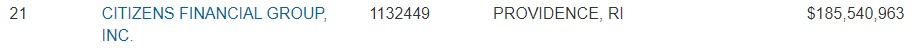

# Section 1

# CITIZENS FINANCIAL GROUP, INC
### Commercial & Consumer Banking
#### - Their primary business unit is for consumer and commercial banking and it operates in 11 states with over 1000 branches. Their largest assets classes as of 6/30/2021 were in real estate loans, commercial loans, and loans to individuals. With each making up 28.7%, 20.8% and 16% of their total assets respectively. 
### Citizens Securities, LLC
#### - This business unit handles the investing arm of the bank, it is devoted to consumers planning for retirement, education plans and personal portfolios. They offer a number of products such as IRAs, Fixed annuities, 529 College Savings Plans, Stocks Bonds, ETFs and Mutual Funds. In their latest NE1 you can see the percentage of orders they direct to venues for trading. Citadel Securities and Virtu Americas fulfill almost 90% of their orders for securities traded on NYSE or NASDAQ exchanges. 

# Section 2: Parsing ownership data from Yahoo Finance page

In [368]:
opts = webdriver.ChromeOptions()
opts.headless =True
driver =webdriver.Chrome(options = opts)

In [369]:
holders_url = "https://finance.yahoo.com/quote/CFG/holders?p=CFG"
insider_roster_url ="https://finance.yahoo.com/quote/CFG/insider-roster?p=CFG"
insider_transactions_url = "https://finance.yahoo.com/quote/CFG/insider-transactions?p=CFG"

In [370]:
def get_table(url):
    driver.get(url)
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, 'lxml')
    tables = soup.find_all('table')
    return tables

In [371]:
ownership_table = get_table(holders_url)
insider_roster = get_table(insider_roster_url)
insider_transactions_table = get_table(insider_transactions_url)

In [372]:
def get_cleaned_data(tables, data_name):
    writer = pd.ExcelWriter(data_name +".xlsx", engine='xlsxwriter')
    for i1 in range(0, len(tables)):
        table = tables[i1]
        col_names=[]
        for i in table.find_all("thead"):
            rows = i.find_all('tr')
            for row in rows:
                value = row.find_all("th")
                for j in value:
                    col_names.append(j.text)

        lst2=[]
        for i in table.find_all("tbody"):
            rows=i.find_all('tr')
            for row in rows:
                value = row.find_all("td")
                lst1=[]
                for j in value:
                    lst1.append(j.text)
                lst2.append(lst1)
        if len(col_names)==0:
            df = pd.DataFrame(lst2)
        else:
            df= pd.DataFrame(lst2, columns = col_names)
        sheet = data_name+str(i1)
        df.to_excel(writer, sheet_name=sheet, index=False)
    writer.save()

In [373]:
get_cleaned_data(ownership_table, "holder_data")
get_cleaned_data(insider_roster,"insider_roster")
get_cleaned_data(insider_transactions_table, "insider_transactions")

# Section 3: Calculating Annual stock return, beta and volatility

In [375]:
ret_data= pd.read_csv(r'C:\Users\whill\anaconda3\BHC Analysis\msf_new2.csv', usecols=['CUSIP', 'DATE', 'SHRCD', 'RET', 'VWRETD'])

In [376]:
ret_data.columns = ret_data.columns.str.lower()
ret_data = ret_data[ret_data.cusip == "17461010"]
ret_data = ret_data.loc[ret_data["shrcd"].isin([10.0, 11.0])]
ret_data['date'] = ret_data['date'].apply(str)
ret_data['year']= ret_data['date'].str[:4]
ret_data["date"] = pd.to_datetime(ret_data["date"])
ret_data['ret'] = pd.to_numeric(ret_data['ret'], errors = 'coerce')
ret_data = ret_data[ret_data['ret'].notna()]
ret_data['date'] = ret_data['date'].dt.strftime('%Y%m')

In [377]:
factor_data = pd.read_csv("https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip",skiprows=3,sep=","
                         ,header=0, names =['date','mkt_rf', 'smb', 'hml', 'rf'])
cols = factor_data.columns.drop('date')
factor_data[cols] = factor_data[cols].apply(pd.to_numeric, errors='coerce')/100
ret_data = ret_data.merge(factor_data, on='date', how='inner')

In [378]:
ret_data = ret_data.assign(excess_ret= ret_data['ret']-ret_data['rf'],
               excess_mkt_ret= ret_data['vwretd']-ret_data['rf'])

In [379]:
def regress(data, yvar, xvar):
    Y = data[yvar]
    X = data[xvar]
    #X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params


#This is what you need
betas = ret_data.groupby('year').apply(regress, 'excess_ret', 'excess_mkt_ret')
betas = betas.rename(columns={"excess_mkt_ret" : "beta_1yr"}) 

In [380]:
vol_data = ret_data.groupby('year').std()[['ret']]
vol_data = vol_data.rename(columns={"ret" : "volatility"}) 
annual_ret = pd.DataFrame(ret_data.groupby('year')['ret'].apply(lambda x : ((1+x).prod()-1)))
annual_data = pd.merge(betas, vol_data, on='year', how='inner')
annual_data = pd.merge(annual_data, annual_ret, on='year', how='inner')
annual_data

,beta_1yr,volatility,ret
year,,,
2014,1.254994,0.021975,0.065796
2015,0.658946,0.050099,0.069757
2016,2.684615,0.127751,0.387438
2017,1.832656,0.063257,0.199385
2018,1.289518,0.067270,-0.274517
2019,1.828604,0.091374,0.418856
2020,1.812622,0.166239,-0.067327


# Section 3: Parsing Short-interest and days it takes to cover the short-interest

In [381]:
short_rate_url ="https://fintel.io/ss/us/cfg"

In [382]:
data_tables = get_table(short_rate_url)

In [383]:
table = data_tables[7]
def get_ind_table_data(table):
        col_names=[]
        for i in table.find_all("thead"):
            rows = i.find_all('tr')
            for row in rows:
                value = row.find_all("th")
                for j in value:
                    col_names.append(j.text)

        lst2=[]
        for i in table.find_all("tbody"):
            rows=i.find_all('tr')
            for row in rows:
                value = row.find_all("td")
                lst1=[]
                for j in value:
                    lst1.append(j.text)
                lst2.append(lst1)
        if len(col_names)==0:
            df = pd.DataFrame(lst2)
        else:
            df= pd.DataFrame(lst2, columns = col_names)
        return df

In [384]:
df = get_ind_table_data(table)
df = df.iloc[:,:4]

In [385]:
df['Short Interest'] = df['Short Interest'].str.replace("\n", "")
df['Short Interest'] = df['Short Interest'].str.replace(",", "")
df['Percent Change'] = df['Percent Change'].str.replace("\n","")
df['Days to Cover'] = df['Days to Cover'].str.replace("\n", "")

In [386]:
cols = df.columns.drop('SettlementDate')
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [387]:
df

,SettlementDate,Short Interest,Percent Change,Days to Cover
0,2021-10-15,9840446,-4.69,2.39
1,2021-09-30,10324861,19.89,1.91
2,2021-09-15,8612041,4.58,2.24
3,2021-08-31,8234935,1.19,2.22
4,2021-08-13,8137980,26.83,1.75
5,2021-07-30,6416513,16.47,1.18
6,2021-07-15,5509135,-8.15,1.35
7,2021-06-30,5998191,-0.31,1.33
8,2021-06-15,6016704,-3.61,1.57
9,2021-05-28,6240683,-9.23,1.79


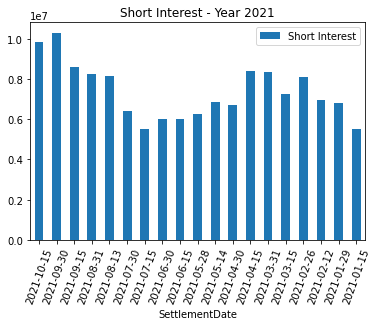

In [393]:
df.plot.bar(x="SettlementDate", y="Short Interest", rot=70, title="Short Interest - Year 2021");

plot.show(block=True)

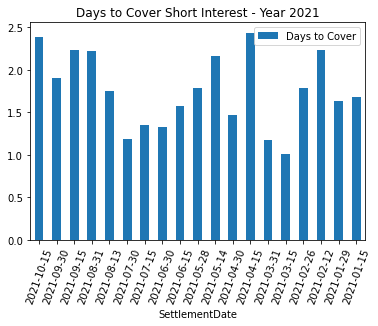

In [395]:
df.plot.bar(x="SettlementDate", y="Days to Cover", rot=70, title="Days to Cover Short Interest - Year 2021");

plot.show(block=True)

# Section 3: Parsing credit Rating of Citizens Financial Group, Inc.

In [396]:
credit_rating_url = "https://investor.citizensbank.com/about-us/investor-relations/fixed-income-capital-information/credit-ratings.aspx"

In [397]:
credit_rating = get_table(credit_rating_url)

In [398]:
df = get_ind_table_data(credit_rating[0])

In [399]:
df = df.iloc[1:,:]

In [400]:
df

,0,1,2,3
1,,S&P,Moody's,Fitch Ratings
2,Long-term issuer,BBB+,-,BBB+
3,Short-term issuer,A-2,-,F1
4,Subordinated debt,BBB,-,BBB
5,Preferred stock,BB+,-,BB


# Section 3: Parsing Analyst opinions/estimates from Yahoo Finance

In [401]:
analyst_estimate_url ="https://finance.yahoo.com/quote/CFG/analysis?p=CFG"

In [402]:
analyst_data = get_table(analyst_estimate_url)

In [403]:
get_cleaned_data(analyst_data, "analyst_estimates")

In [404]:
df = get_ind_table_data(analyst_data[0])
df

,Earnings Estimate,Current Qtr. (Dec 2021),Next Qtr. (Mar 2022),Current Year (2021),Next Year (2022)
0,No. of Analysts,16,12,16,15
1,Avg. Estimate,1.13,0.95,5.16,4.08
2,Low Estimate,1.07,0.83,5.09,3.23
3,High Estimate,1.18,1.12,5.52,5.82
4,Year Ago EPS,0.99,1.37,2.22,5.16


In [405]:
df1 = get_ind_table_data(analyst_data[1])
df1

,Revenue Estimate,Current Qtr. (Dec 2021),Next Qtr. (Mar 2022),Current Year (2021),Next Year (2022)
0,No. of Analysts,12,7,14,12
1,Avg. Estimate,1.66B,1.66B,6.58B,7.32B
2,Low Estimate,1.64B,1.61B,6.57B,6.75B
3,High Estimate,1.68B,1.7B,6.62B,7.69B
4,Year Ago Sales,1.71B,1.66B,6.91B,6.58B
5,Sales Growth (year/est),-3.00%,-0.20%,-4.60%,11.10%


In [406]:
df2 = get_ind_table_data(analyst_data[3])
df2

,EPS Trend,Current Qtr. (Dec 2021),Next Qtr. (Mar 2022),Current Year (2021),Next Year (2022)
0,Current Estimate,1.13,0.95,5.16,4.08
1,7 Days Ago,1.13,0.95,5.16,4.11
2,30 Days Ago,1.12,0.93,5.12,4.26
3,60 Days Ago,1.12,0.94,5.11,4.29
4,90 Days Ago,1.13,1,5.11,4.35


# Section 4
1. earnings
2. net interest margins
3. non-interest or fee income
4. revenues, expenses
5. loan mix
6. past due and losses
7. losses and loan reserves
8. liquidity and funding
9. capitalization ratios
10. growth rates
11. asset composition
12. liability composition
13. liquidity and funding (important)
14. maturity gap
15. interest rate sensitivity
16. what is the major source of the bank performance?
17. how did the bank perform compared to the peers?

## RATIO GRAPHS: 
For each section there is a ratio graph (multiple if some ratios are disproportionaly larger) that shows the value of the ratio at the end of the year for the last 5 years. With these graphs we are able to see how these values change year over year and we can use this to determine the growth in the banks' assets, liabilities and equity. We can also see if defaults are increasing for certain loan types Y-O-Y. This data gives us insight about specific patterns within the bank and how it operates.

## PG Rank Graphs:
For each ratio graph (with the exception of revenues and expenses) there are Peer Group Percentile Rankings Y-O-Y for the last 5 years. This show us how the bank is ranked in terms of its peer group as defined by the BHCPR report. An increase or decrease in these values can help us determine the banks' financial security and risk when compared to other banks of its size and their ratio values. Some analysis on the Peer Group Ranking will be provided at the end. 

In [407]:
dt = '20201231'
urlstr = 'https://www.ffiec.gov/npw/FinancialReport/ReturnFinancialReportCSV?rpt=BHCPR&id=1132449&dt=' + dt
req = requests.get(urlstr)
urlcontent = req.content
filename = dt + 'downloaded.csv'
csv_file = open(filename, 'wb')
csv_file.write(urlcontent)
csv_file.close()

In [408]:
def getdata(fname, testlist):
    daterange2 = ['12/31/2020', '12/31/2019', '12/31/2018', '12/31/2017', '12/31/2016']
    df = pd.read_csv(fname, header =None, skiprows=15)
    df.rename(columns={0: 'ID', 1:'Ratio Type', 2: 'Value'}, inplace=True)
    df['Value'] = pd.to_numeric(df['Value'], errors = 'coerce')
    df['COUNT'] = df.groupby(['Ratio Type']).cumcount()+1
    df = df.set_index(['Ratio Type', 'COUNT'])['Value'].unstack().add_prefix('col').reset_index()
    df.rename(columns={'COUNT': 'Index', 'col1': daterange2[0], 'col2':daterange2[1], 'col3': daterange2[2], 
                       'col4':daterange2[3], 'col5': daterange2[4]}, inplace=True)
    df = df[df['Ratio Type'].isin(testlist)]
    df = df[['Ratio Type','12/31/2020', '12/31/2019', '12/31/2018', '12/31/2017', '12/31/2016']]
    df.set_index('Ratio Type', inplace = True)
    df = df.transpose()
    df = df.sort_index(axis=0)
    return df

In [409]:
def peergrouplisttransform(samplelist):
    for i in range(len(samplelist)):
        samplelist[i] = "PG RANK: " + samplelist[i]
    return samplelist

## EARNINGS RATIOS

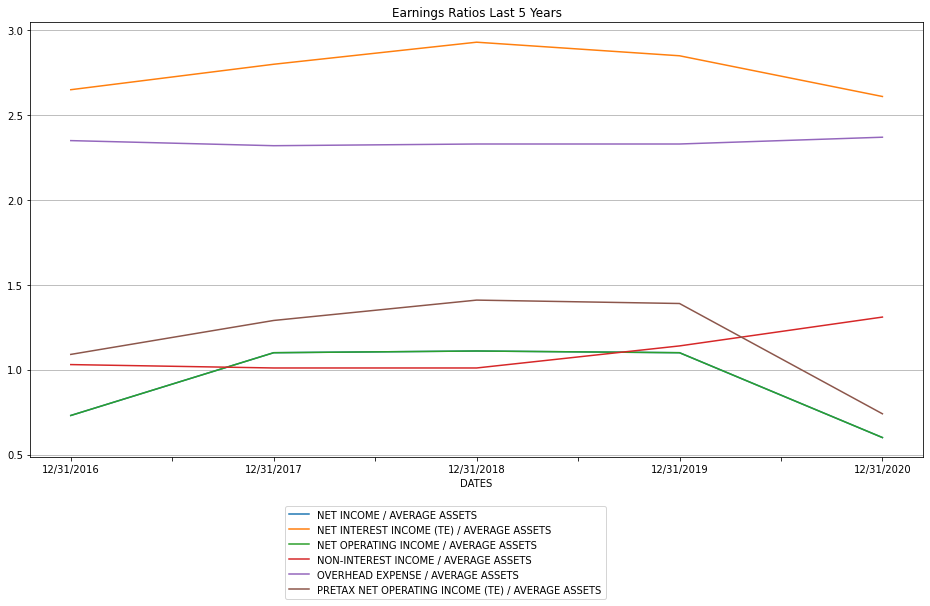

In [410]:
earningsratiolist = ['NET INTEREST INCOME (TE) / AVERAGE ASSETS', 'NON-INTEREST INCOME / AVERAGE ASSETS', 'OVERHEAD EXPENSE / AVERAGE ASSETS',
                       'PRETAX NET OPERATING INCOME (TE) / AVERAGE ASSETS', 'NET OPERATING INCOME / AVERAGE ASSETS', 'NET INCOME / AVERAGE ASSETS']
df = getdata(filename, earningsratiolist)
ax = df.plot(figsize=(16,8), title='Earnings Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

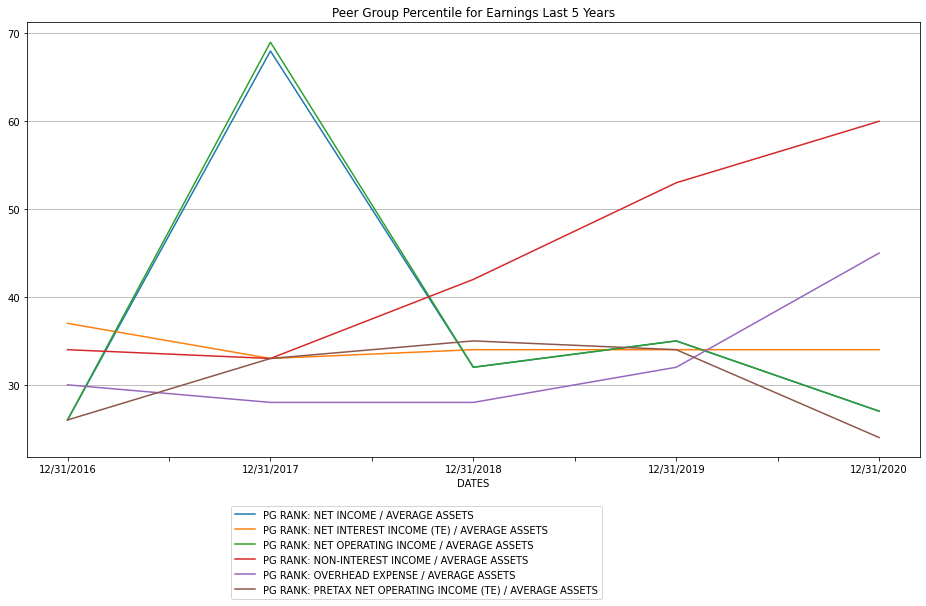

In [411]:
pgrankearnings = peergrouplisttransform(earningsratiolist)
df = getdata(filename, pgrankearnings)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Earnings Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Net Interest Margins

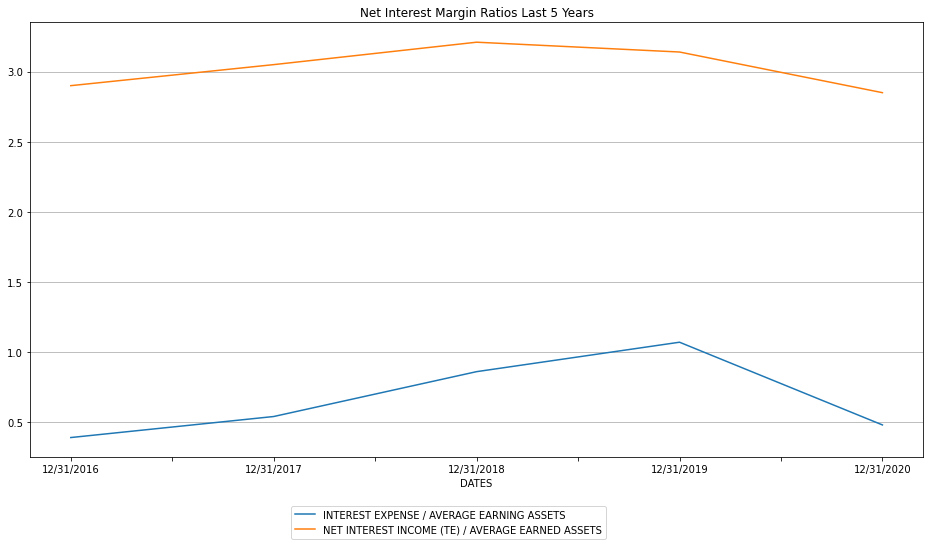

In [412]:
netintmarginratiolist = ['NET INTEREST INCOME (TE) / AVERAGE EARNED ASSETS', 'INTEREST EXPENSE / AVERAGE EARNING ASSETS']
df = getdata(filename, netintmarginratiolist)
ax = df.plot(figsize=(16,8), title='Net Interest Margin Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

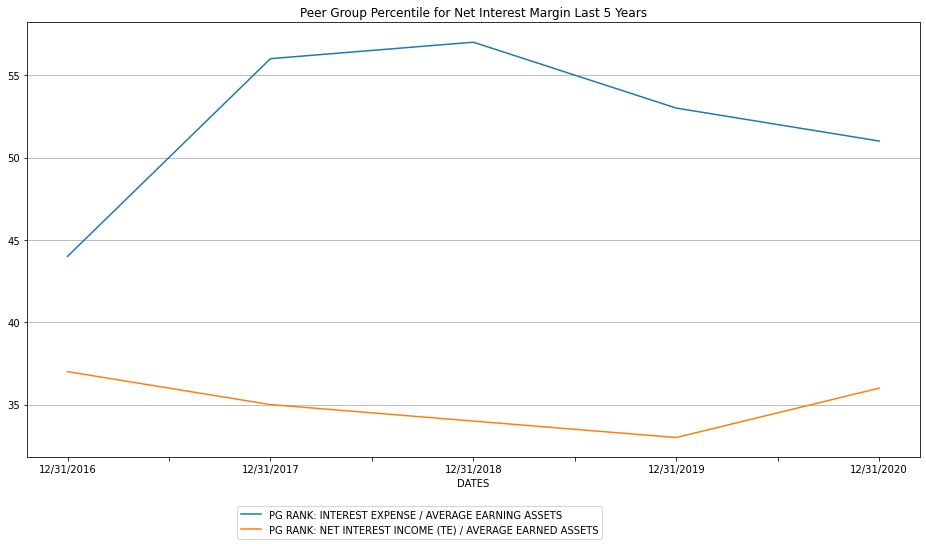

In [413]:
pgranknetintmargin = peergrouplisttransform(netintmarginratiolist)
df = getdata(filename, pgranknetintmargin)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Net Interest Margin Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Non-Interest or Fee Income

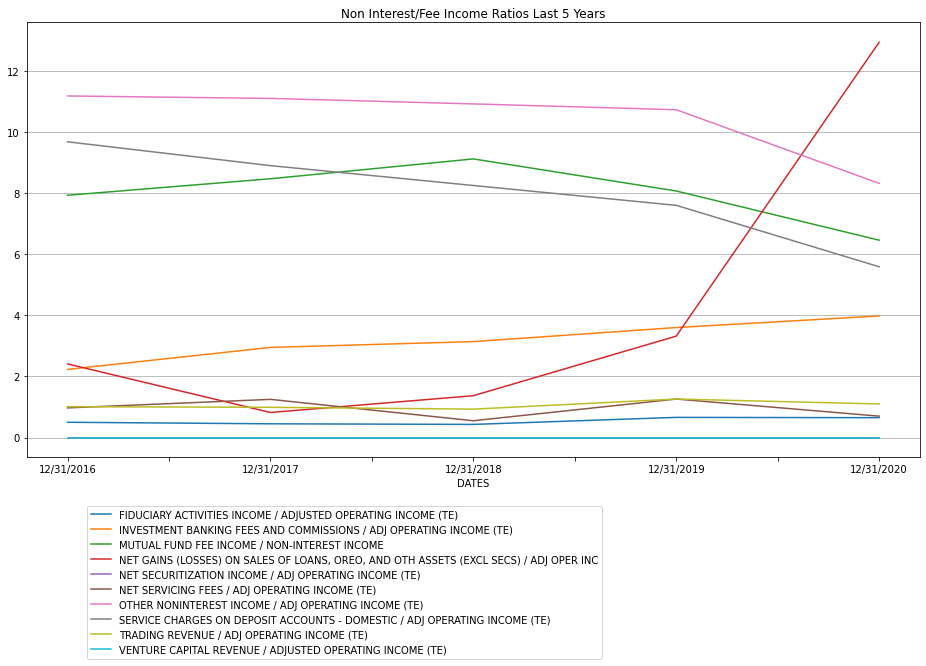

In [414]:
feeincomeratiolist = ['MUTUAL FUND FEE INCOME / NON-INTEREST INCOME', 'INVESTMENT BANKING FEES AND COMMISSIONS / ADJ OPERATING INCOME (TE)',
                        'FIDUCIARY ACTIVITIES INCOME / ADJUSTED OPERATING INCOME (TE)','SERVICE CHARGES ON DEPOSIT ACCOUNTS - DOMESTIC / ADJ OPERATING INCOME (TE)',
                         'TRADING REVENUE / ADJ OPERATING INCOME (TE)','VENTURE CAPITAL REVENUE / ADJUSTED OPERATING INCOME (TE)','NET SERVICING FEES / ADJ OPERATING INCOME (TE)',
                       'NET SECURITIZATION INCOME / ADJ OPERATING INCOME (TE)', 'NET GAINS (LOSSES) ON SALES OF LOANS, OREO, AND OTH ASSETS (EXCL SECS) / ADJ OPER INC', 
                        'OTHER NONINTEREST INCOME / ADJ OPERATING INCOME (TE)']
df = getdata(filename, feeincomeratiolist)
ax = df.plot(figsize=(16,8), title='Non Interest/Fee Income Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

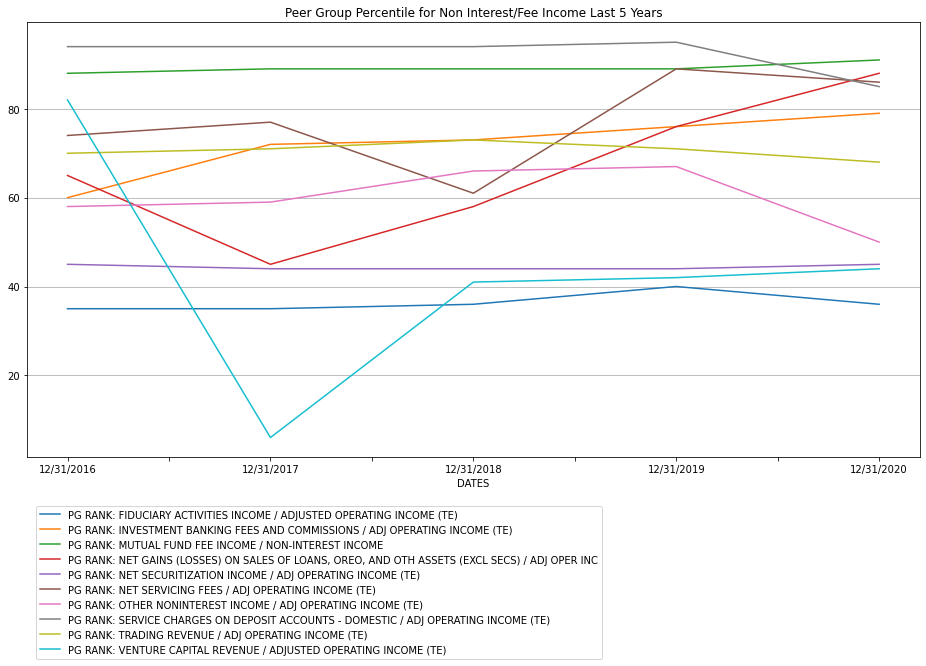

In [415]:
pgrankfeeincome = peergrouplisttransform(feeincomeratiolist)
df = getdata(filename, pgrankfeeincome)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Non Interest/Fee Income Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Revenues and Expenses

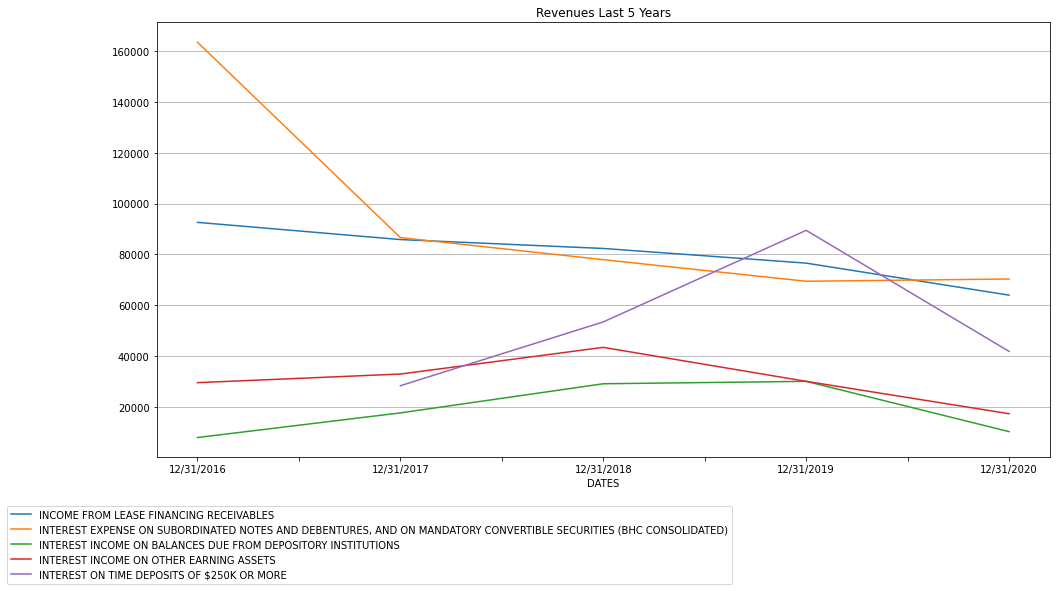

In [416]:
revenuelist = ['INTEREST INCOME ON BALANCES DUE FROM DEPOSITORY INSTITUTIONS','INTEREST ON TIME DEPOSITS OF $250K OR MORE',
                'INCOME FROM LEASE FINANCING RECEIVABLES', 'INTEREST EXPENSE ON SUBORDINATED NOTES AND DEBENTURES, AND ON MANDATORY CONVERTIBLE SECURITIES (BHC CONSOLIDATED)',
               'INTEREST INCOME ON OTHER EARNING ASSETS']
df = getdata(filename, revenuelist)
ax = df.plot(figsize=(16,8), title='Revenues Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

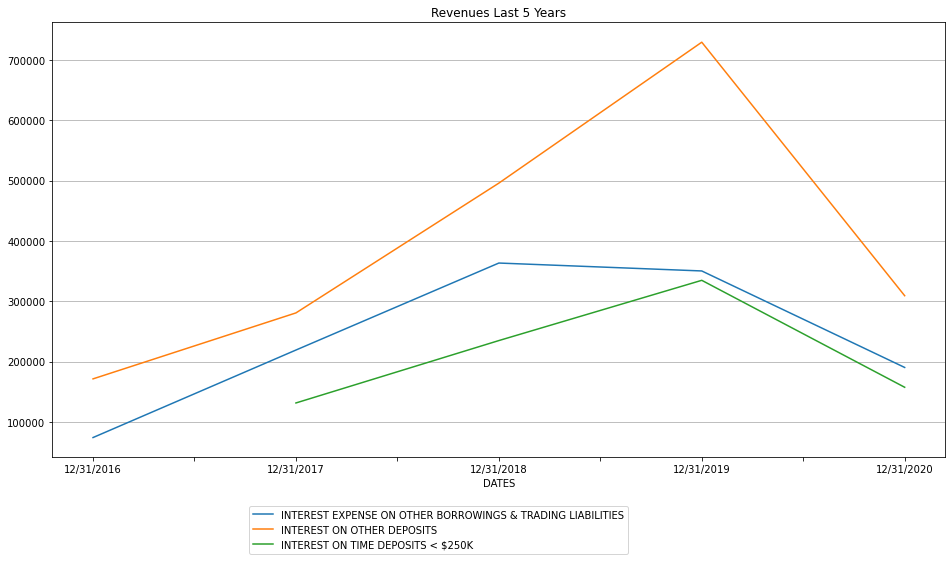

In [417]:
revenue2list = ['INTEREST ON TIME DEPOSITS < $250K', 'INTEREST ON OTHER DEPOSITS',
                'INTEREST EXPENSE ON OTHER BORROWINGS & TRADING LIABILITIES']
df = getdata(filename, revenue2list)
ax = df.plot(figsize=(16,8), title='Revenues Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

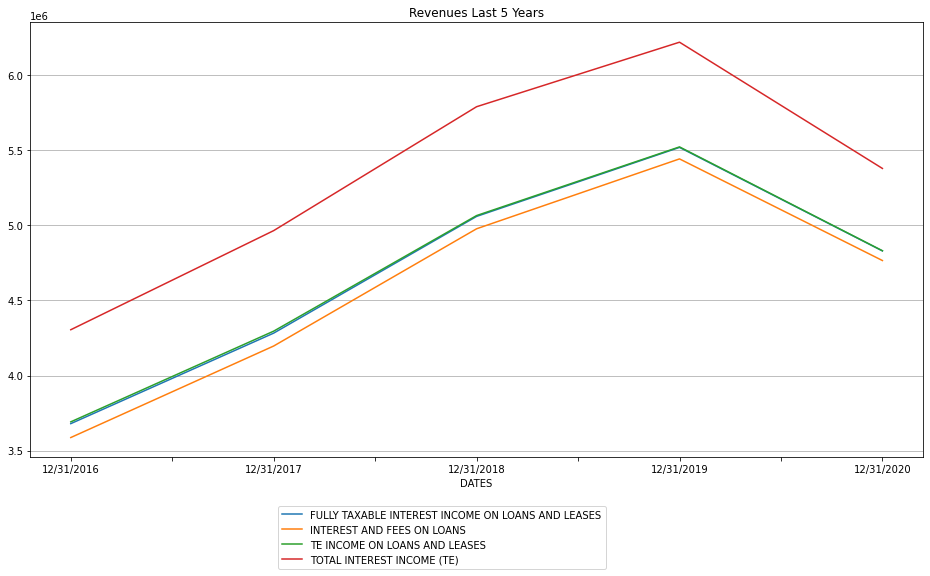

In [418]:
revenue3list = ['INTEREST AND FEES ON LOANS','FULLY TAXABLE INTEREST INCOME ON LOANS AND LEASES','TE INCOME ON LOANS AND LEASES', 'TOTAL INTEREST INCOME (TE)']
df = getdata(filename, revenue3list)
ax = df.plot(figsize=(16,8), title='Revenues Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

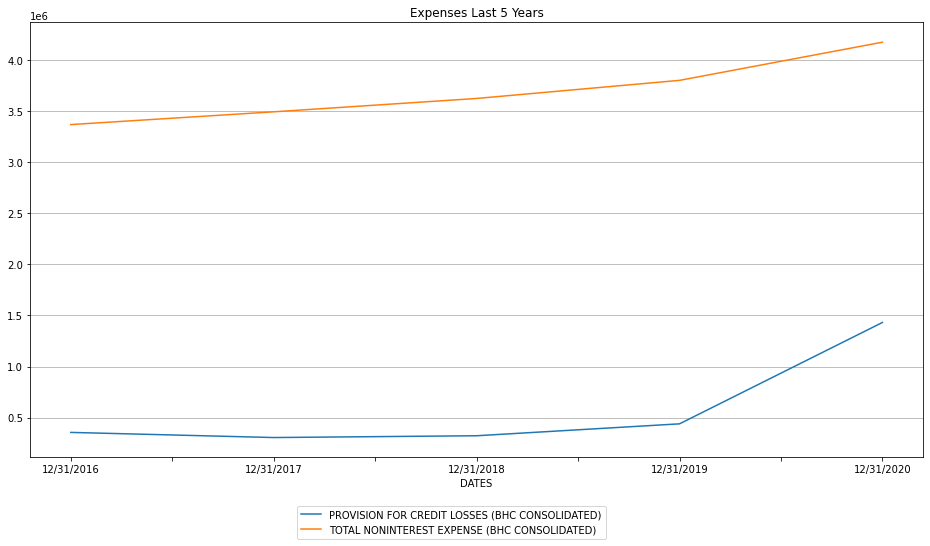

In [419]:
expenselist = ['TOTAL NONINTEREST EXPENSE (BHC CONSOLIDATED)','PROVISION FOR CREDIT LOSSES (BHC CONSOLIDATED)']
df = getdata(filename, expenselist)
ax = df.plot(figsize=(16,8), title='Expenses Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

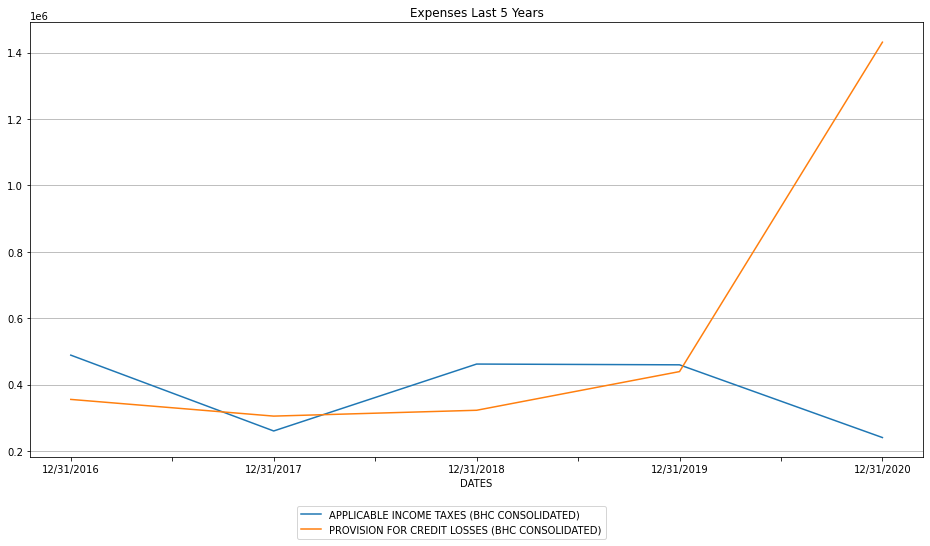

In [420]:
expense2list = ['APPLICABLE INCOME TAXES (BHC CONSOLIDATED)','PROVISION FOR CREDIT LOSSES (BHC CONSOLIDATED)']
df = getdata(filename, expense2list)
ax = df.plot(figsize=(16,8), title='Expenses Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Loan Mix

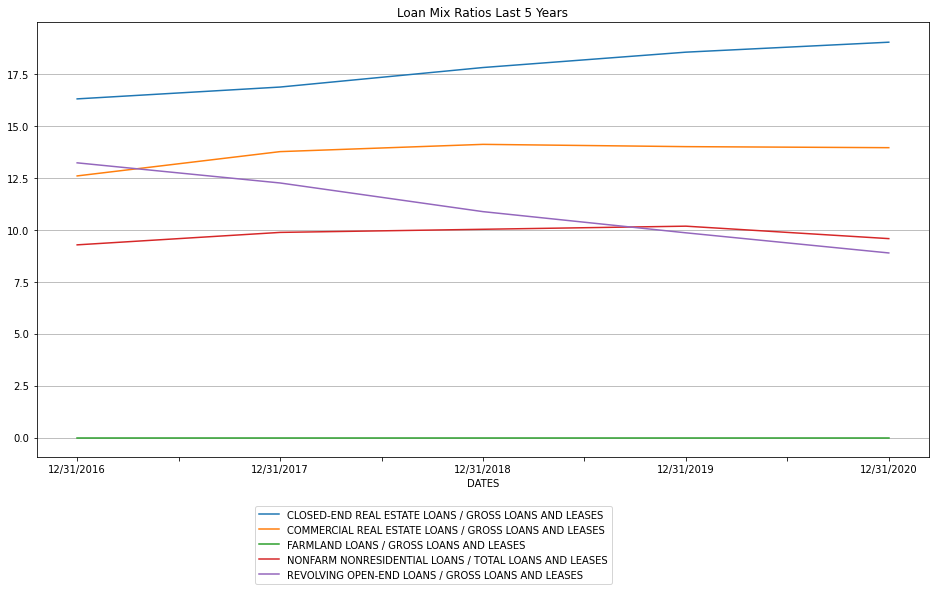

In [421]:
loanmixratiolist = ['REVOLVING OPEN-END LOANS / GROSS LOANS AND LEASES','CLOSED-END REAL ESTATE LOANS / GROSS LOANS AND LEASES',
                    'COMMERCIAL REAL ESTATE LOANS / GROSS LOANS AND LEASES','NONFARM NONRESIDENTIAL LOANS / TOTAL LOANS AND LEASES', 
                    'FARMLAND LOANS / GROSS LOANS AND LEASES']
df = getdata(filename, loanmixratiolist)
ax = df.plot(figsize=(16,8), title='Loan Mix Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

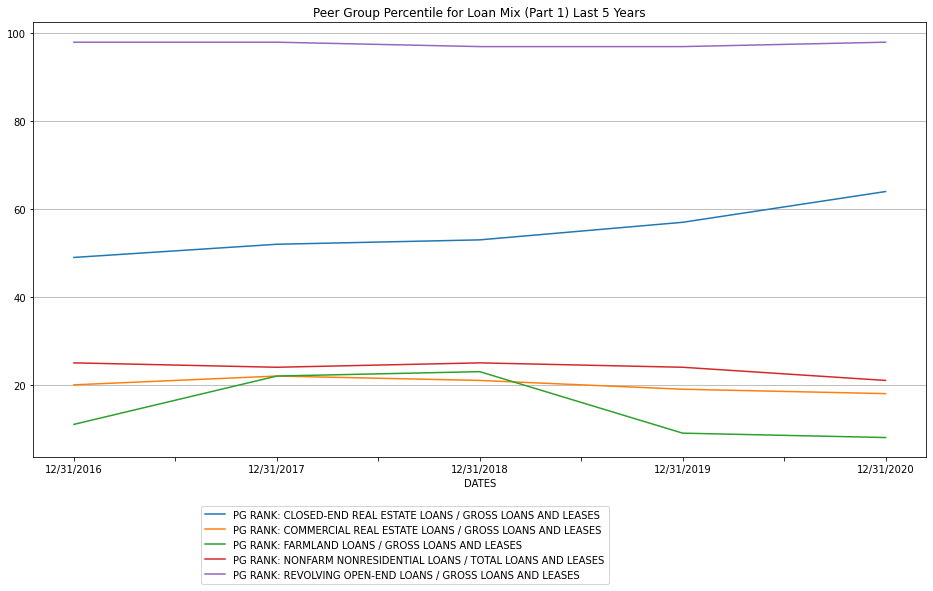

In [422]:
pgrankloanmix = peergrouplisttransform(loanmixratiolist)
df = getdata(filename, pgrankloanmix)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Loan Mix (Part 1) Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

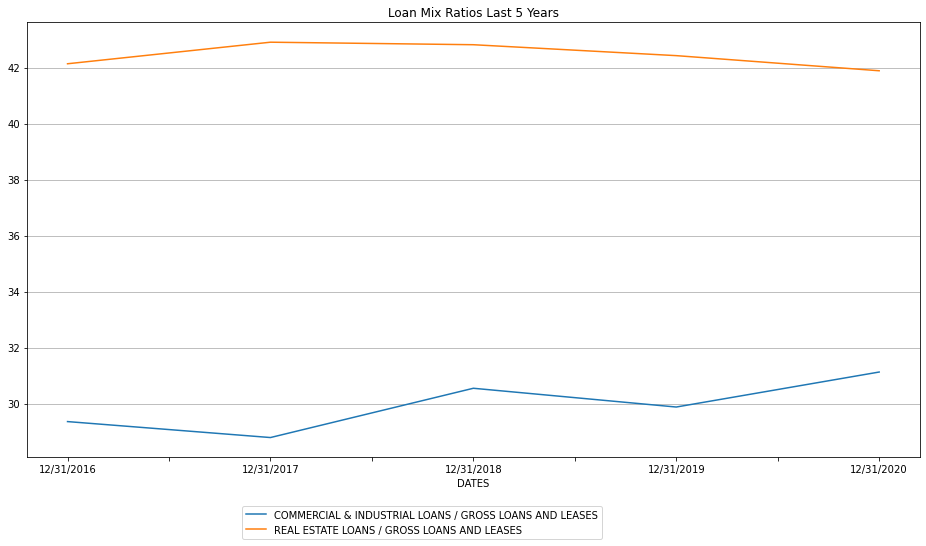

In [423]:
loanmix2ratiolist = ['COMMERCIAL & INDUSTRIAL LOANS / GROSS LOANS AND LEASES','REAL ESTATE LOANS / GROSS LOANS AND LEASES']
df = getdata(filename, loanmix2ratiolist)
ax = df.plot(figsize=(16,8), title='Loan Mix Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

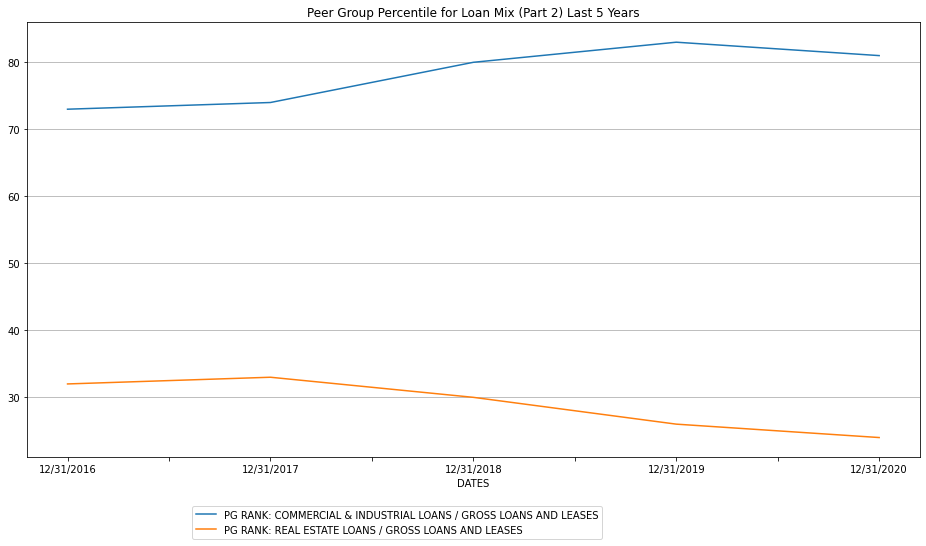

In [424]:
pgrankloanmix2 = peergrouplisttransform(loanmix2ratiolist)
df = getdata(filename, pgrankloanmix2)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Loan Mix (Part 2) Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

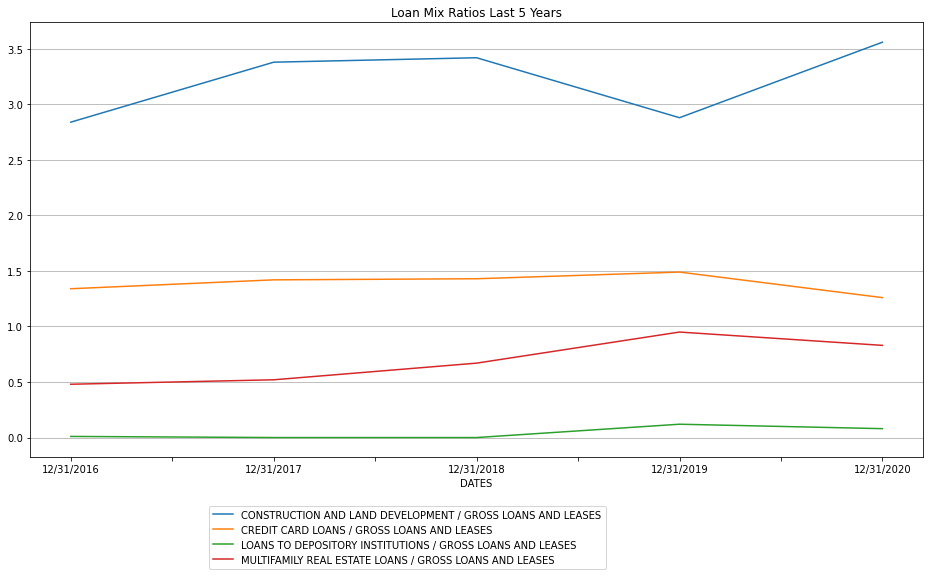

In [425]:
loanmix3ratiolist = ['CONSTRUCTION AND LAND DEVELOPMENT / GROSS LOANS AND LEASES', 'CREDIT CARD LOANS / GROSS LOANS AND LEASES',
'MULTIFAMILY REAL ESTATE LOANS / GROSS LOANS AND LEASES','LOANS TO DEPOSITORY INSTITUTIONS / GROSS LOANS AND LEASES']
df = getdata(filename, loanmix3ratiolist)
ax = df.plot(figsize=(16,8), title='Loan Mix Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

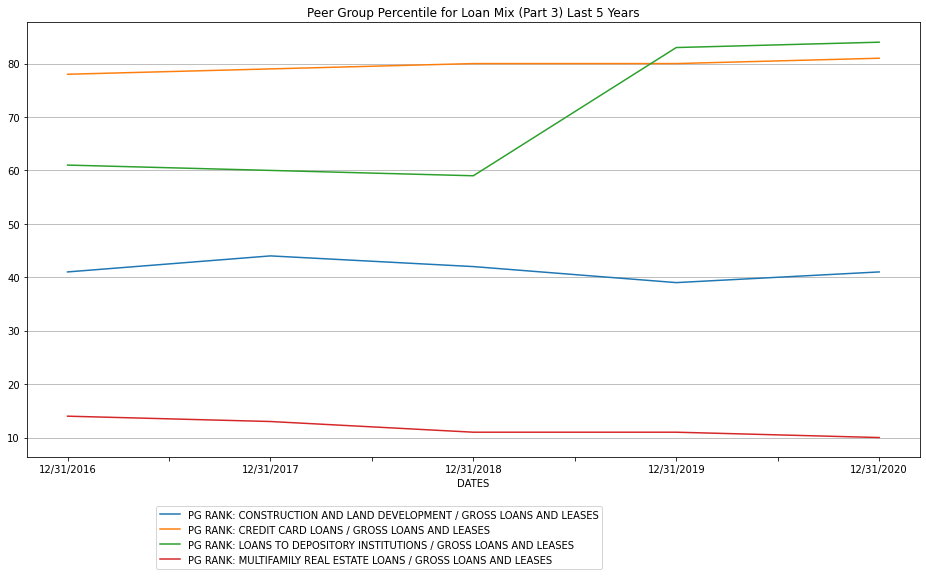

In [426]:
pgrankloanmix3 = peergrouplisttransform(loanmix3ratiolist)
df = getdata(filename, pgrankloanmix3)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Loan Mix (Part 3) Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Past Due & Losses

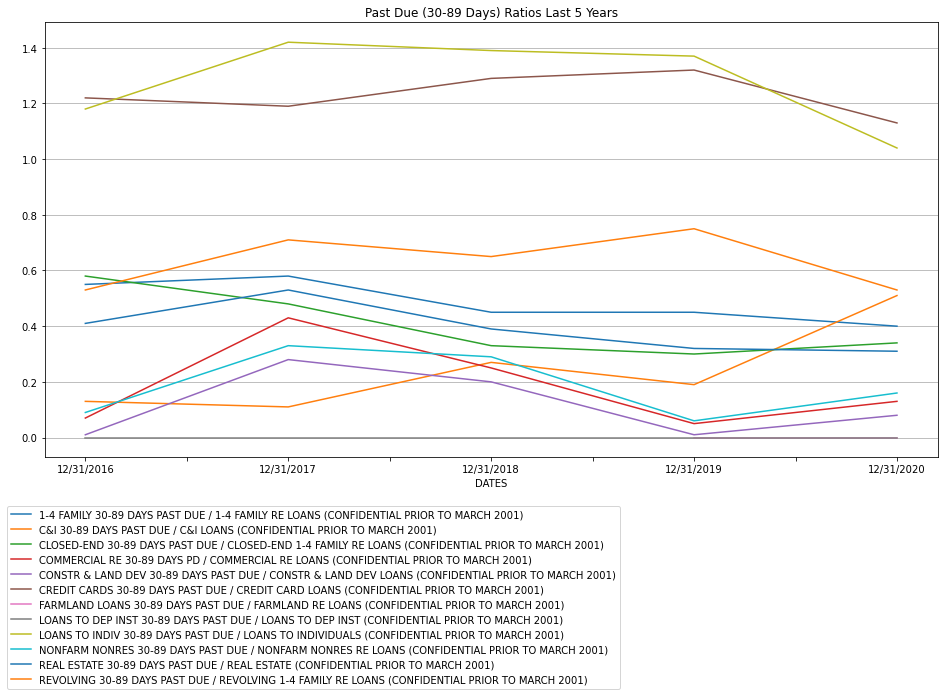

In [427]:
pastdue30ratiolist = ['REAL ESTATE 30-89 DAYS PAST DUE / REAL ESTATE (CONFIDENTIAL PRIOR TO MARCH 2001)', 'LOANS TO INDIV 30-89 DAYS PAST DUE / LOANS TO INDIVIDUALS (CONFIDENTIAL PRIOR TO MARCH 2001)',
'LOANS TO DEP INST 30-89 DAYS PAST DUE / LOANS TO DEP INST (CONFIDENTIAL PRIOR TO MARCH 2001)','OTHER LOANS & LEASES 30-89 DAYS PAST DUE / OTHER LOANS & LEASES (CONFIDENTIAL PRIOR TO MARCH 2001',
                    '1-4 FAMILY 30-89 DAYS PAST DUE / 1-4 FAMILY RE LOANS (CONFIDENTIAL PRIOR TO MARCH 2001)','REVOLVING 30-89 DAYS PAST DUE / REVOLVING 1-4 FAMILY RE LOANS (CONFIDENTIAL PRIOR TO MARCH 2001)',
                    'CLOSED-END 30-89 DAYS PAST DUE / CLOSED-END 1-4 FAMILY RE LOANS (CONFIDENTIAL PRIOR TO MARCH 2001)','COMMERCIAL RE 30-89 DAYS PD / COMMERCIAL RE LOANS (CONFIDENTIAL PRIOR TO MARCH 2001)',
                    'CONSTR & LAND DEV 30-89 DAYS PAST DUE / CONSTR & LAND DEV LOANS (CONFIDENTIAL PRIOR TO MARCH 2001)',
                    'NONFARM NONRES 30-89 DAYS PAST DUE / NONFARM NONRES RE LOANS (CONFIDENTIAL PRIOR TO MARCH 2001)','FARMLAND LOANS 30-89 DAYS PAST DUE / FARMLAND RE LOANS (CONFIDENTIAL PRIOR TO MARCH 2001)',
                    'CREDIT CARDS 30-89 DAYS PAST DUE / CREDIT CARD LOANS (CONFIDENTIAL PRIOR TO MARCH 2001)','C&I 30-89 DAYS PAST DUE / C&I LOANS (CONFIDENTIAL PRIOR TO MARCH 2001)',
                    ]
df = getdata(filename, pastdue30ratiolist)
ax = df.plot(figsize=(16,8), title='Past Due (30-89 Days) Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

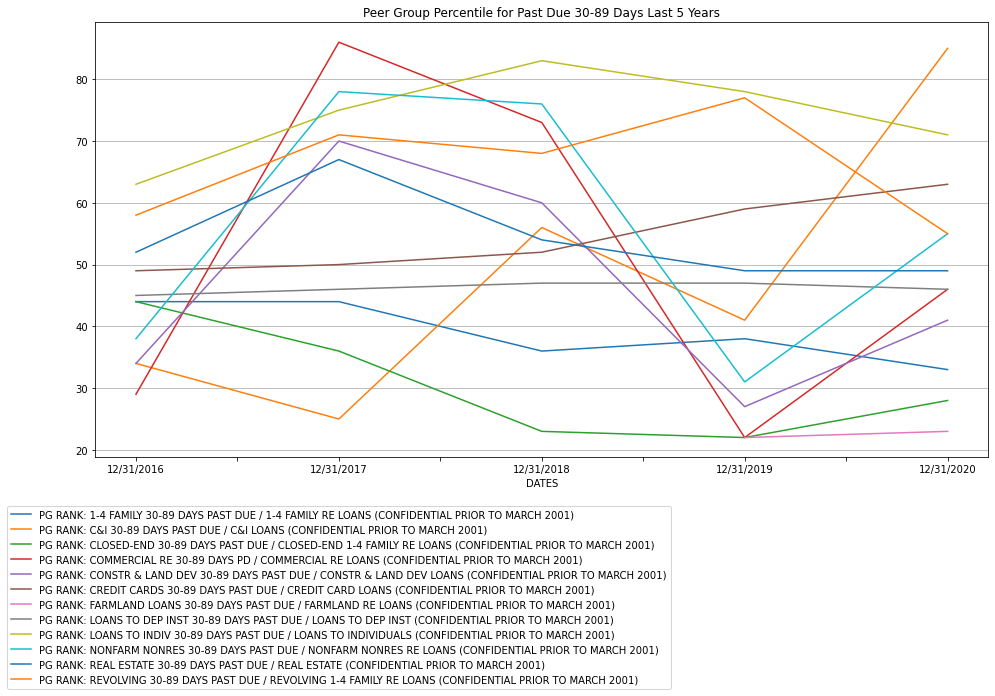

In [428]:
pgrankpastdue30 = peergrouplisttransform(pastdue30ratiolist)
df = getdata(filename, pgrankpastdue30)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Past Due 30-89 Days Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

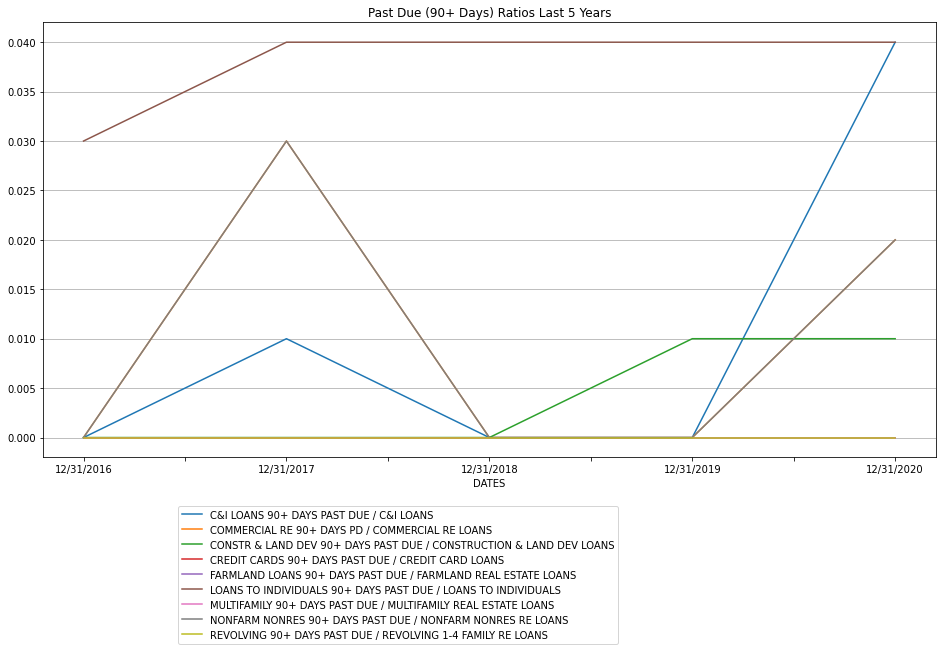

In [429]:
##Information not very valuable limited data and small values
pastdue90ratiolist = [ 'C&I LOANS 90+ DAYS PAST DUE / C&I LOANS','NONFARM NONRES 90+ DAYS PAST DUE / NONFARM NONRES RE LOANS',
                    'LOANS TO INDIVIDUALS 90+ DAYS PAST DUE / LOANS TO INDIVIDUALS','REVOLVING 90+ DAYS PAST DUE / REVOLVING 1-4 FAMILY RE LOANS',
                    'COMMERCIAL RE 90+ DAYS PD / COMMERCIAL RE LOANS','CONSTR & LAND DEV 90+ DAYS PAST DUE / CONSTRUCTION & LAND DEV LOANS',
                    'MULTIFAMILY 90+ DAYS PAST DUE / MULTIFAMILY REAL ESTATE LOANS', 'NONFARM NONRES 90+ DAYS PAST DUE / NONFARM NONRES RE LOANS',
                      'FARMLAND LOANS 90+ DAYS PAST DUE / FARMLAND REAL ESTATE LOANS','CREDIT CARDS 90+ DAYS PAST DUE / CREDIT CARD LOANS'
                    ]
df = getdata(filename, pastdue90ratiolist)
ax = df.plot(figsize=(16,8), title='Past Due (90+ Days) Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

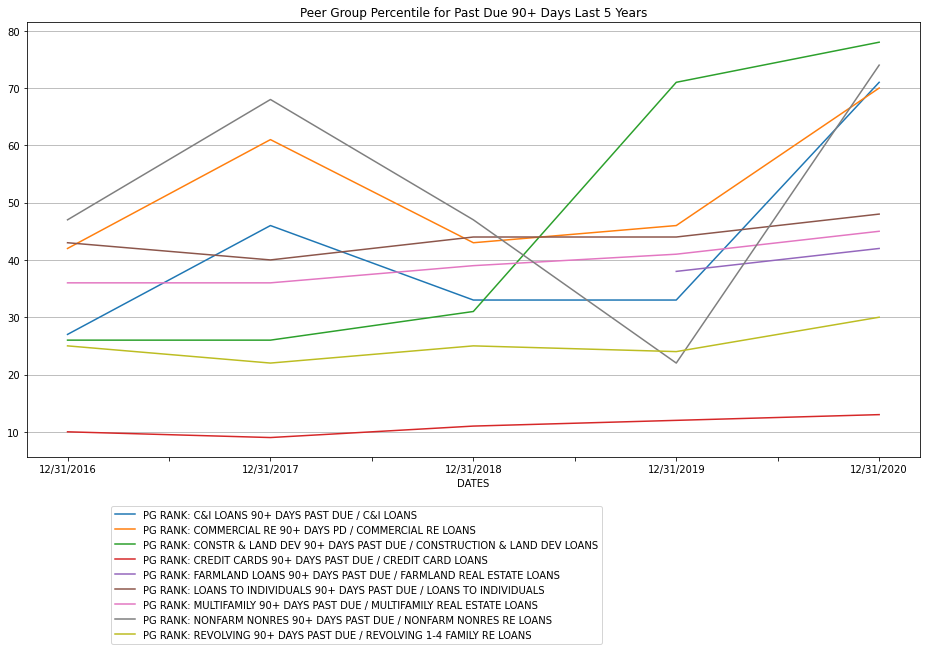

In [430]:
pgrankpastdue90 = peergrouplisttransform(pastdue90ratiolist)
df = getdata(filename, pgrankpastdue90)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Past Due 90+ Days Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

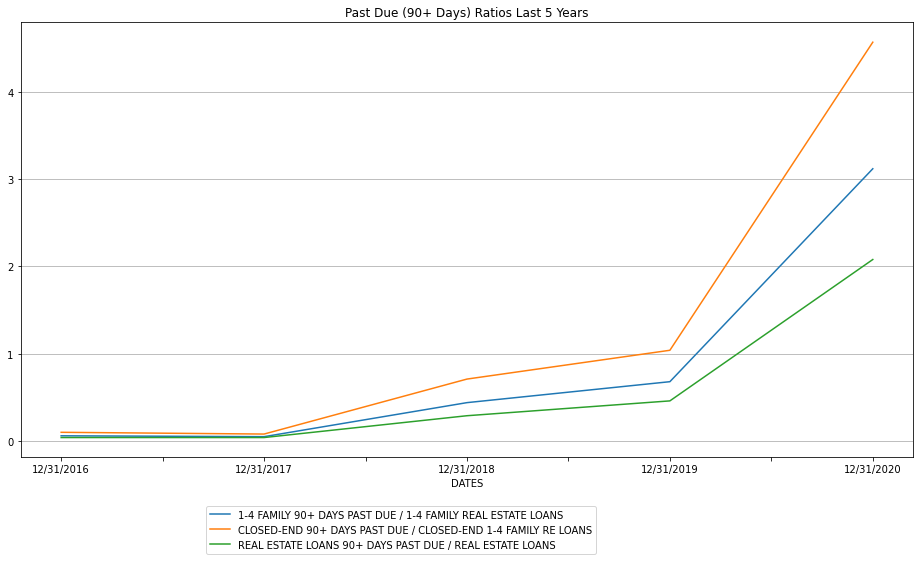

In [431]:
secondpastdue90ratiolist = ['REAL ESTATE LOANS 90+ DAYS PAST DUE / REAL ESTATE LOANS',
                      '1-4 FAMILY 90+ DAYS PAST DUE / 1-4 FAMILY REAL ESTATE LOANS',
                      'CLOSED-END 90+ DAYS PAST DUE / CLOSED-END 1-4 FAMILY RE LOANS']
df = getdata(filename, secondpastdue90ratiolist)
ax = df.plot(figsize=(16,8), title='Past Due (90+ Days) Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

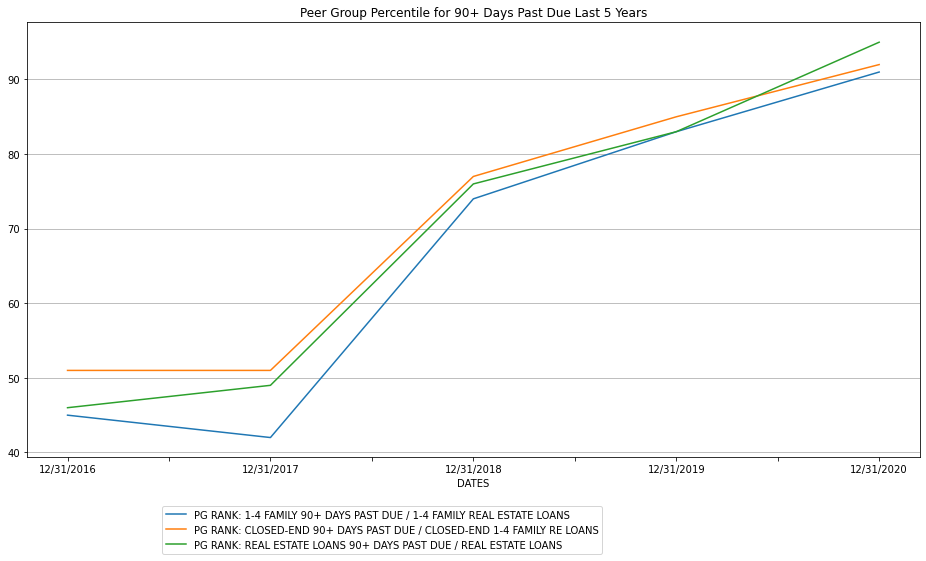

In [432]:
pgratiosecondpastdue90ratiolist = peergrouplisttransform(secondpastdue90ratiolist)
df = getdata(filename, pgratiosecondpastdue90ratiolist)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for 90+ Days Past Due Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

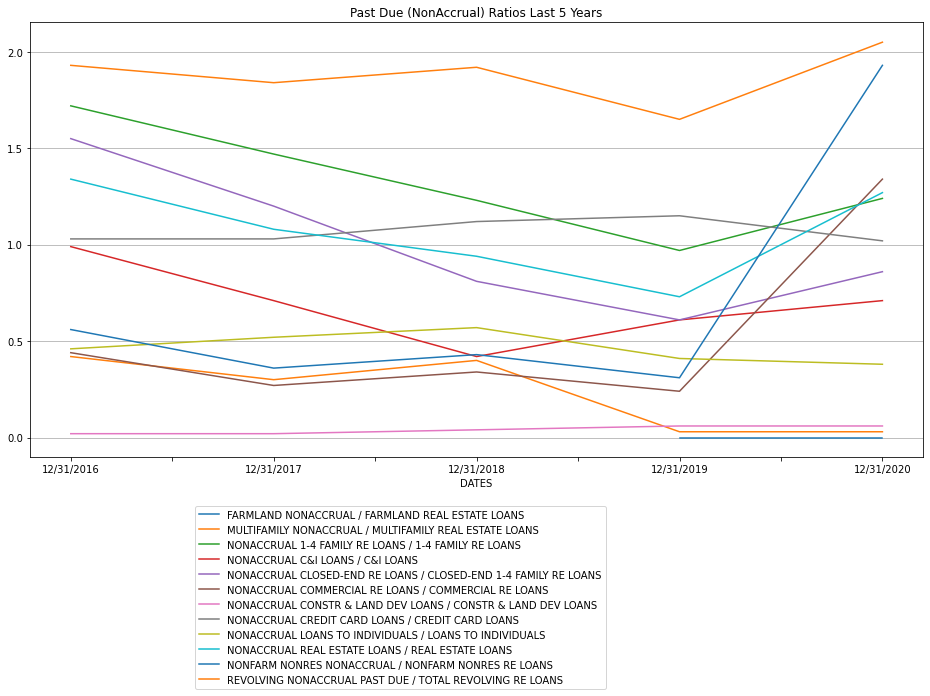

In [433]:
pastduenonaccrualratiolist = [ 'NONACCRUAL REAL ESTATE LOANS / REAL ESTATE LOANS',
                    'NONACCRUAL C&I LOANS / C&I LOANS','NONACCRUAL LOANS TO INDIVIDUALS / LOANS TO INDIVIDUALS',
                    'NONACCRUAL 1-4 FAMILY RE LOANS / 1-4 FAMILY RE LOANS','REVOLVING NONACCRUAL PAST DUE / TOTAL REVOLVING RE LOANS',
                    'NONACCRUAL CLOSED-END RE LOANS / CLOSED-END 1-4 FAMILY RE LOANS', 'NONACCRUAL COMMERCIAL RE LOANS / COMMERCIAL RE LOANS',
                    'NONACCRUAL CONSTR & LAND DEV LOANS / CONSTR & LAND DEV LOANS','MULTIFAMILY NONACCRUAL / MULTIFAMILY REAL ESTATE LOANS',
                    'NONFARM NONRES NONACCRUAL / NONFARM NONRES RE LOANS','FARMLAND NONACCRUAL / FARMLAND REAL ESTATE LOANS',
                               'NONACCRUAL CREDIT CARD LOANS / CREDIT CARD LOANS'
                    ]
df = getdata(filename, pastduenonaccrualratiolist)
ax = df.plot(figsize=(16,8), title='Past Due (NonAccrual) Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

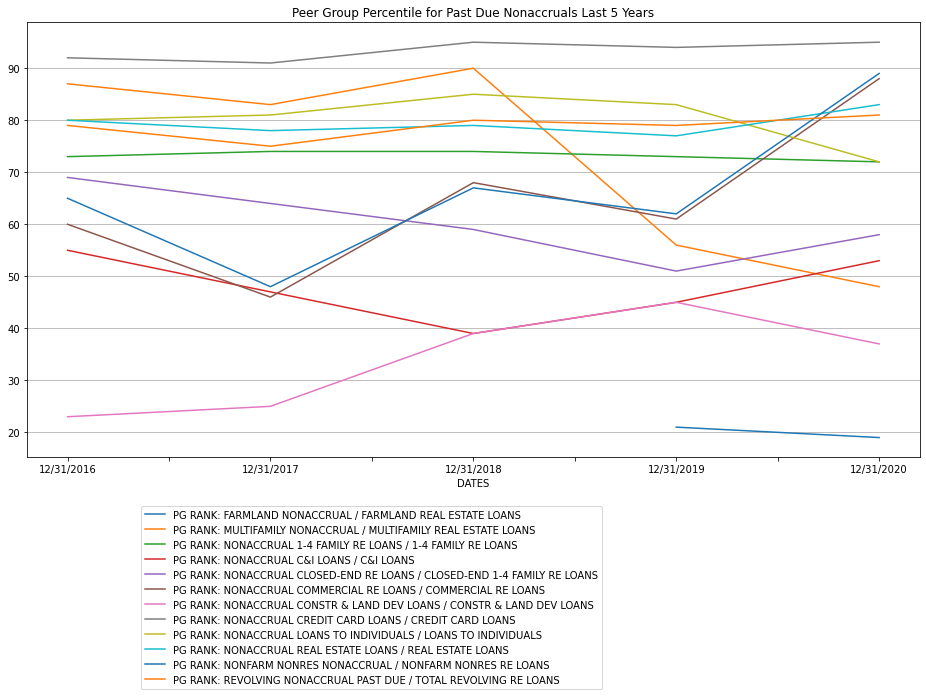

In [434]:
pgrankpastduenonaccrual = peergrouplisttransform(pastduenonaccrualratiolist)
df = getdata(filename, pgrankpastduenonaccrual)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Past Due Nonaccruals Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Losses and Loan Reserves

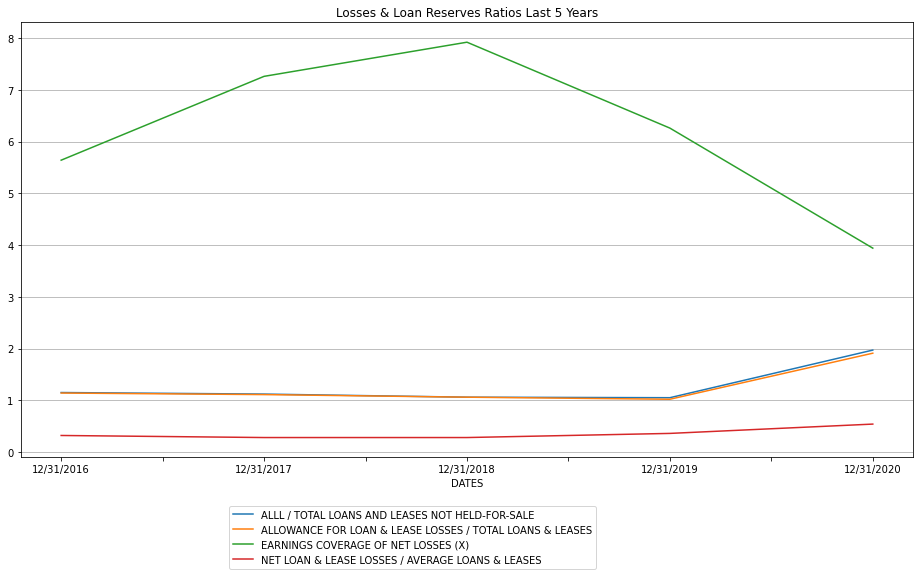

In [435]:
lossesandreservesratiolist = [ 'NET LOAN & LEASE LOSSES / AVERAGE LOANS & LEASES',
                    'ALLOWANCE FOR LOAN & LEASE LOSSES / TOTAL LOANS & LEASES','EARNINGS COVERAGE OF NET LOSSES (X)',
                    'ALLL / TOTAL LOANS AND LEASES NOT HELD-FOR-SALE']
df = getdata(filename, lossesandreservesratiolist)
ax = df.plot(figsize=(16,8), title='Losses & Loan Reserves Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

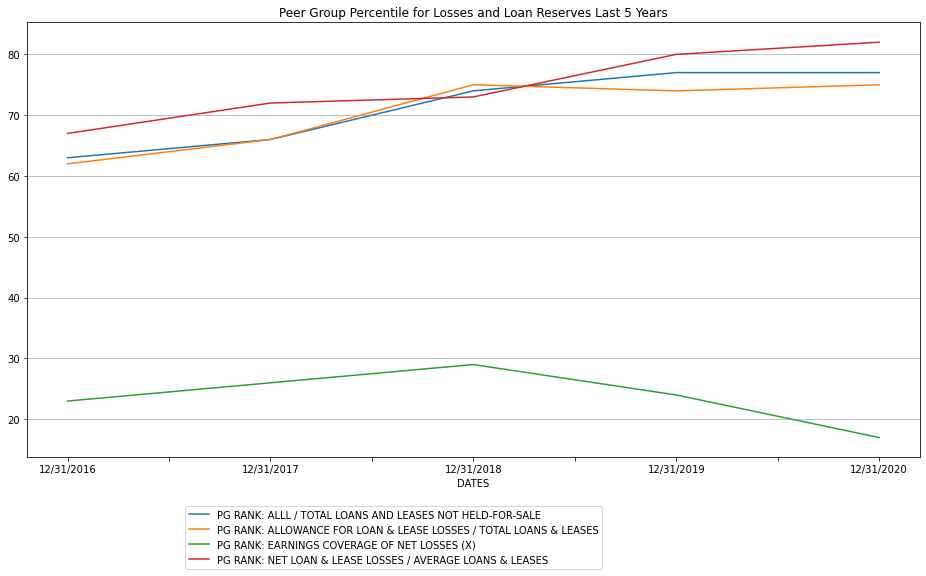

In [436]:
pgranklossesandreserves = peergrouplisttransform(lossesandreservesratiolist)
df = getdata(filename, pgranklossesandreserves)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Losses and Loan Reserves Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Liquidity and Funding

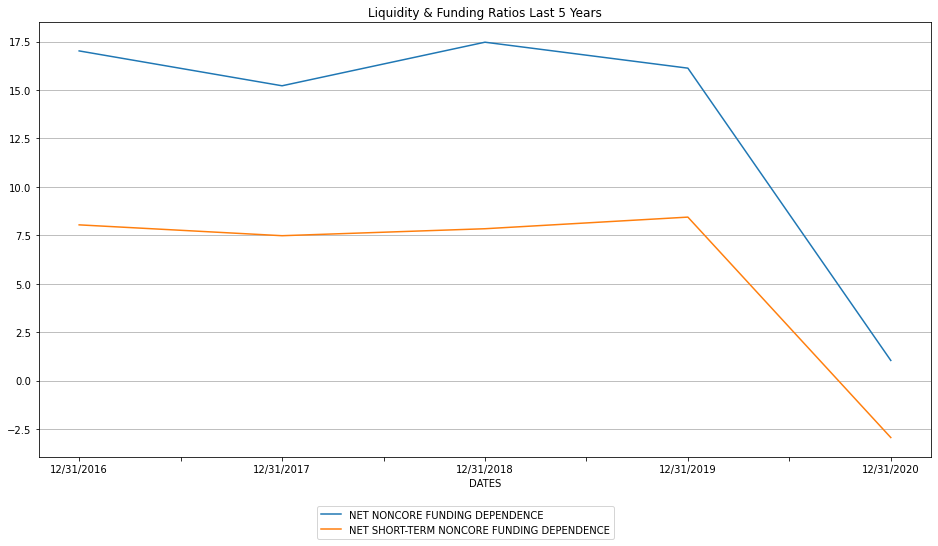

In [437]:
liqudityratiolist = [ 'NET NONCORE FUNDING DEPENDENCE',
                    'NET SHORT-TERM NONCORE FUNDING DEPENDENCE']
df = getdata(filename, liqudityratiolist)
ax = df.plot(figsize=(16,8), title='Liquidity & Funding Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

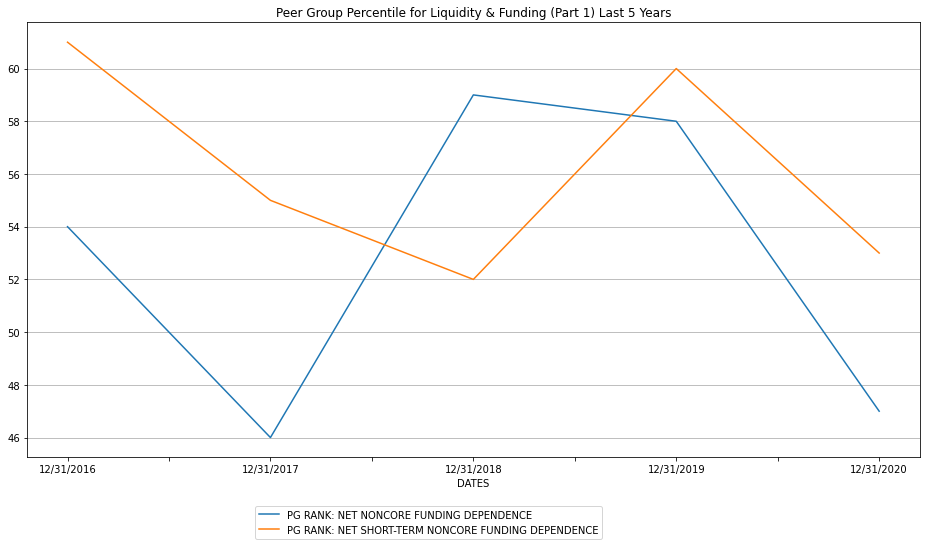

In [438]:
pgrankliqudity = peergrouplisttransform(liqudityratiolist)
df = getdata(filename, pgrankliqudity)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Liquidity & Funding (Part 1) Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

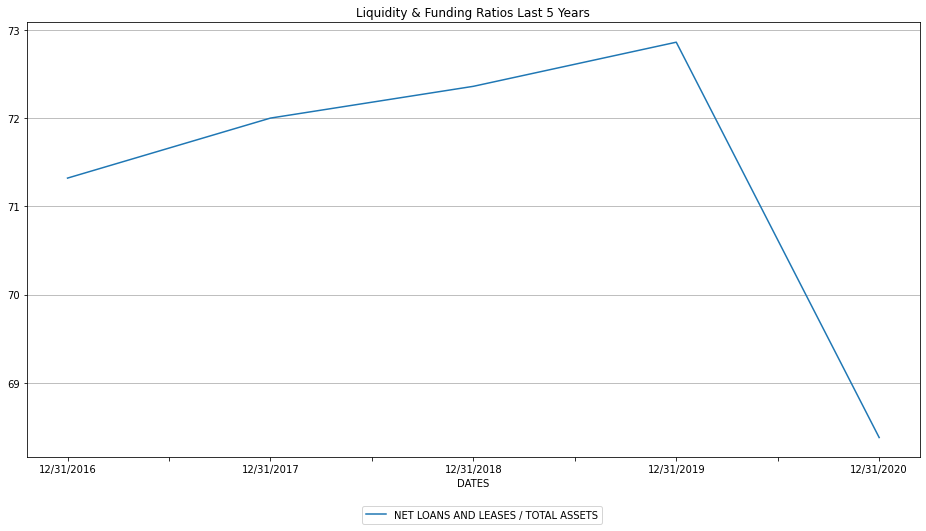

In [439]:
liqudity2ratiolist = [ 'NET LOANS AND LEASES / TOTAL ASSETS']
df = getdata(filename, liqudity2ratiolist)
ax = df.plot(figsize=(16,8), title='Liquidity & Funding Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

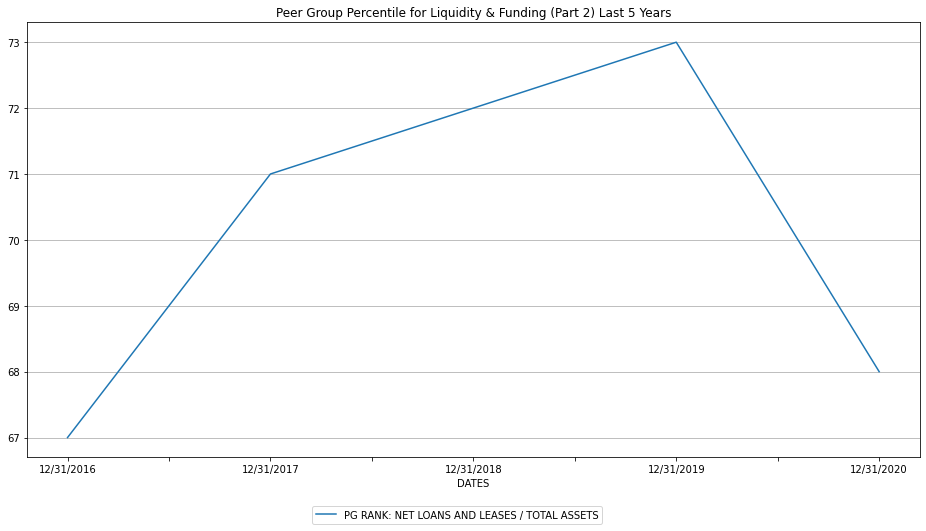

In [440]:
pgrankliqudity2 = peergrouplisttransform(liqudity2ratiolist)
df = getdata(filename, pgrankliqudity2)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Liquidity & Funding (Part 2) Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Capitalization Ratios

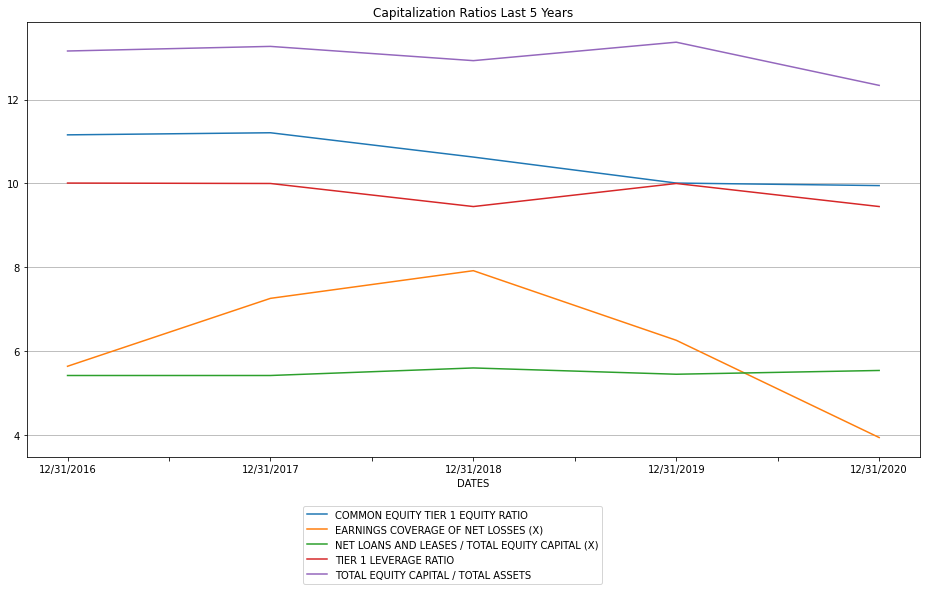

In [441]:
capitalratiolist = [ 'TIER 1 LEVERAGE RATIO',
                    'TOTAL EQUITY CAPITAL / TOTAL ASSETS','EARNINGS COVERAGE OF NET LOSSES (X)',
                    'COMMON EQUITY TIER 1 EQUITY RATIO', 'NET LOANS AND LEASES / TOTAL EQUITY CAPITAL (X)']
df = getdata(filename,capitalratiolist)
ax = df.plot(figsize=(16,8), title='Capitalization Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

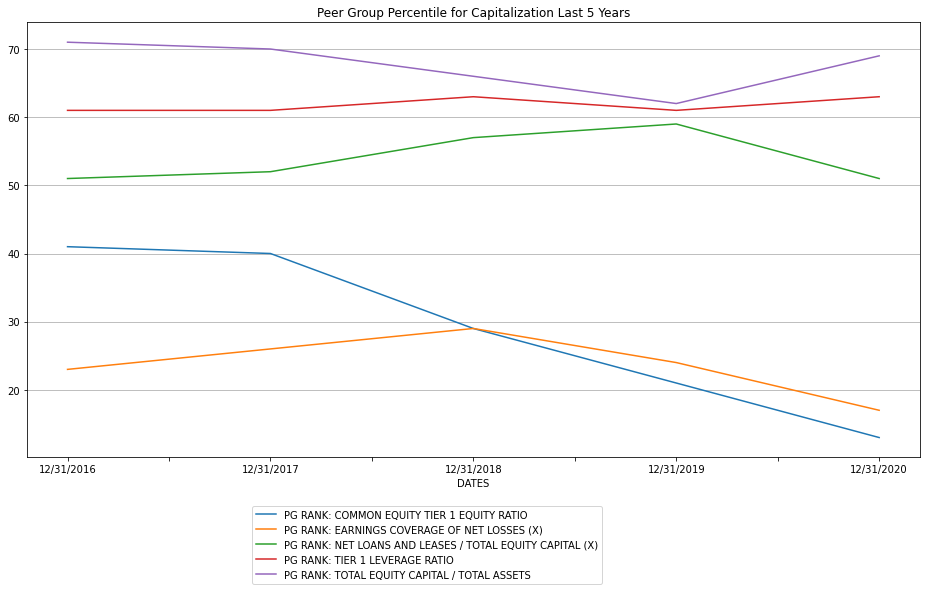

In [442]:
pgrankcapital = peergrouplisttransform(capitalratiolist)
df = getdata(filename, pgrankcapital)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Capitalization Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

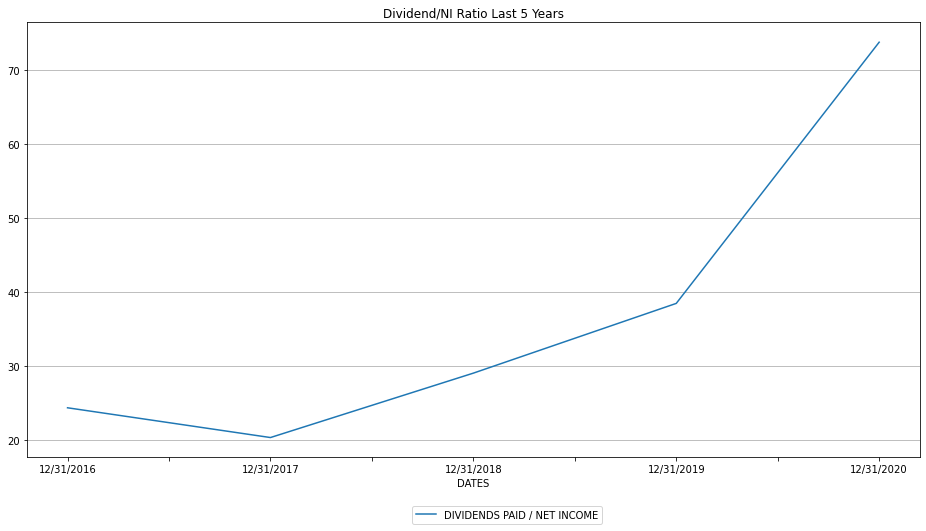

In [443]:
dividendsratiolist = [ 'DIVIDENDS PAID / NET INCOME']
df = getdata(filename, dividendsratiolist)
ax = df.plot(figsize=(16,8), title='Dividend/NI Ratio Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

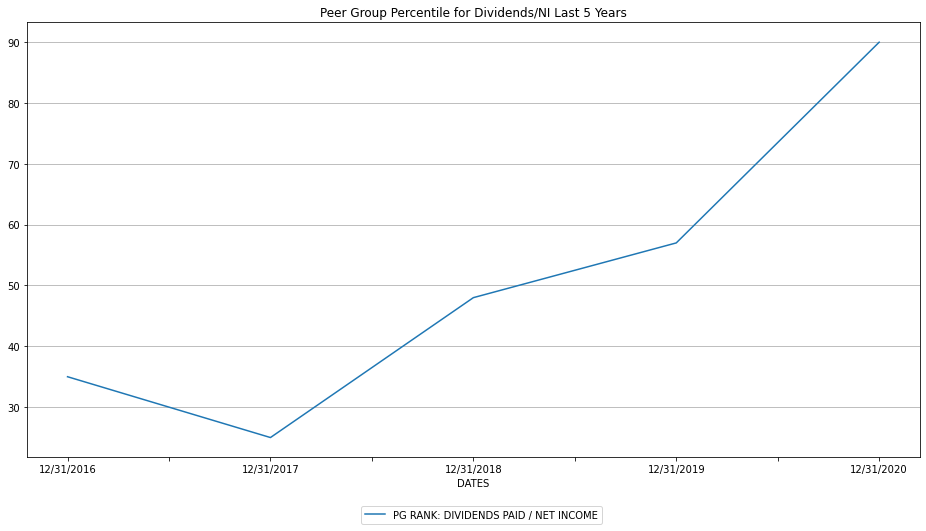

In [444]:
pgratiodividendsratiolist = peergrouplisttransform(dividendsratiolist)
df = getdata(filename, pgratiodividendsratiolist)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Dividends/NI Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Growth Rates

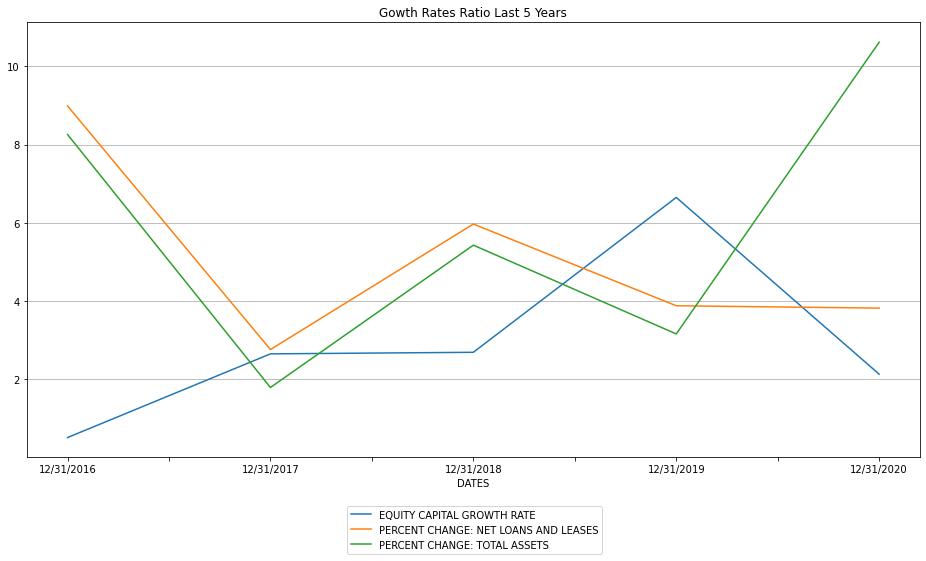

In [445]:
growthratesratiolist = [ 'PERCENT CHANGE: TOTAL ASSETS','EQUITY CAPITAL GROWTH RATE',
                        'PERCENT CHANGE: NET LOANS AND LEASES']
df = getdata(filename, growthratesratiolist)
ax = df.plot(figsize=(16,8), title='Gowth Rates Ratio Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

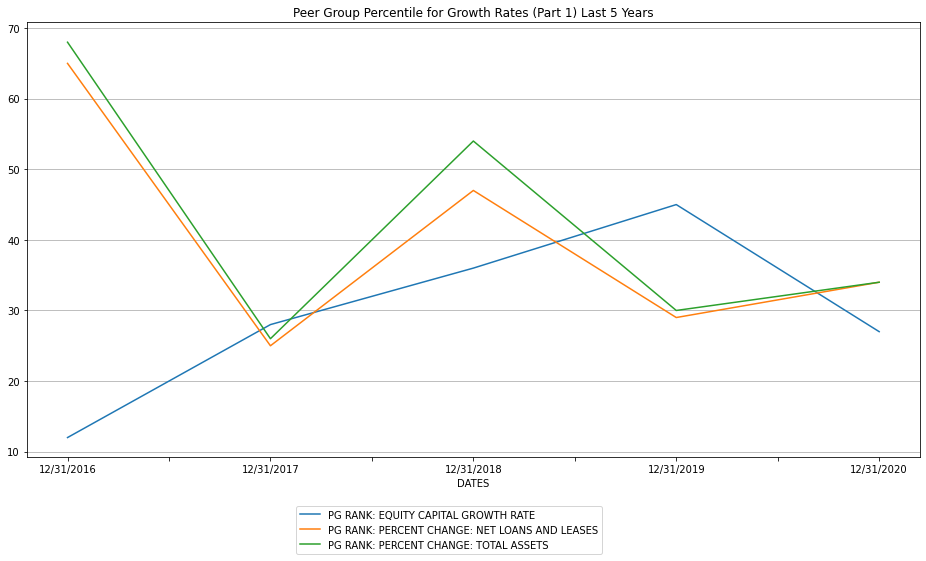

In [446]:
pgrankgrowthrates = peergrouplisttransform(growthratesratiolist)
df = getdata(filename, pgrankgrowthrates)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Growth Rates (Part 1) Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

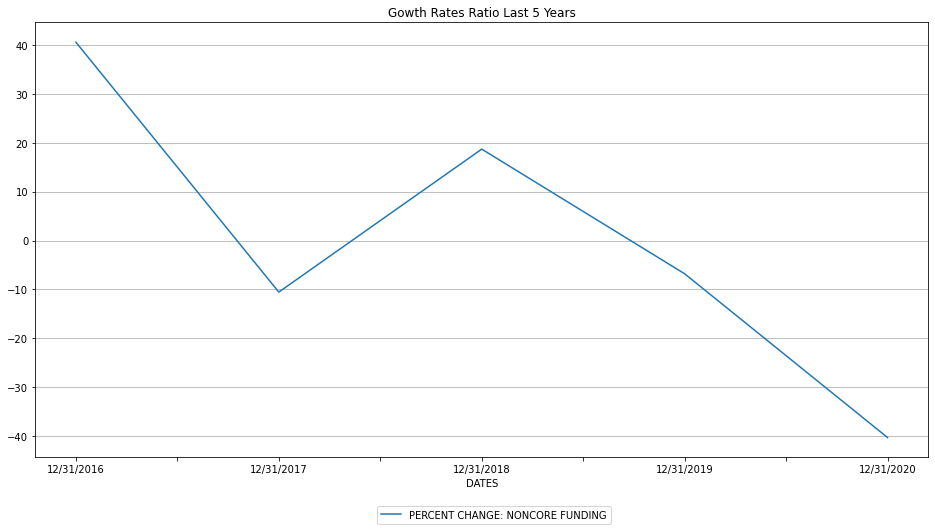

In [447]:
growthrates2ratiolist = ['PERCENT CHANGE: NONCORE FUNDING']
df = getdata(filename, growthrates2ratiolist)
ax = df.plot(figsize=(16,8), title='Gowth Rates Ratio Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

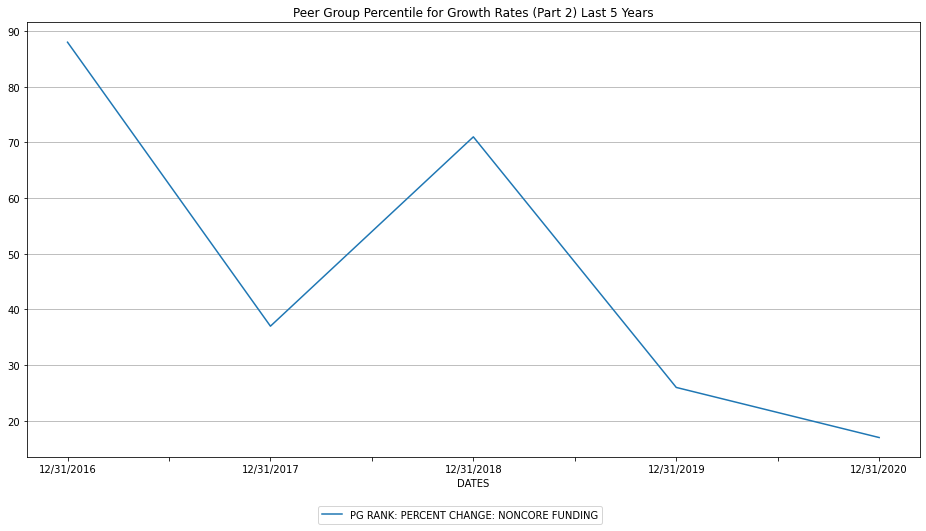

In [448]:
pgrankgrowthrates2 = peergrouplisttransform(growthrates2ratiolist)
df = getdata(filename, pgrankgrowthrates2)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Growth Rates (Part 2) Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Asset Composition

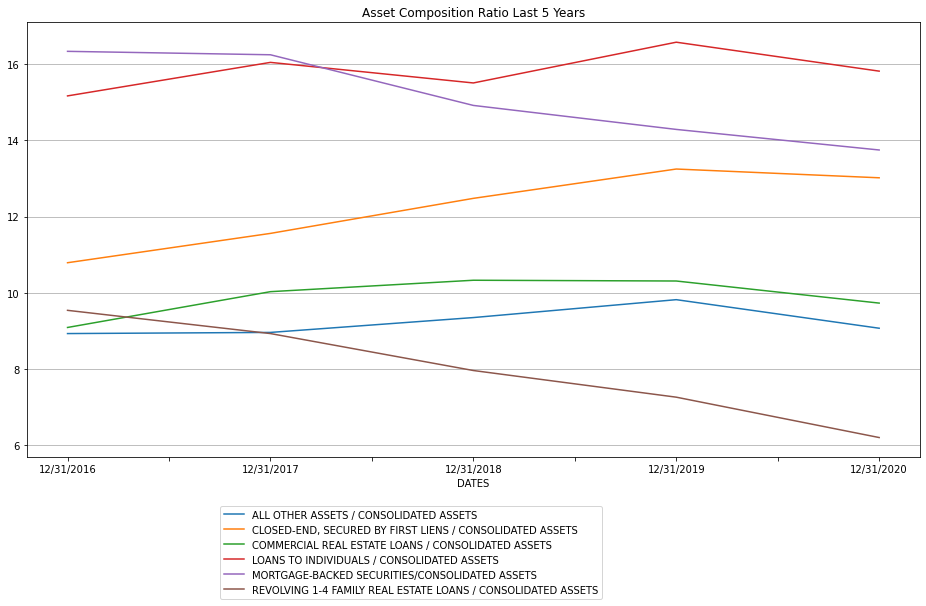

In [449]:
assetcompratiolist = [ 'LOANS TO INDIVIDUALS / CONSOLIDATED ASSETS', 'ALL OTHER ASSETS / CONSOLIDATED ASSETS',
                     'REVOLVING 1-4 FAMILY REAL ESTATE LOANS / CONSOLIDATED ASSETS','CLOSED-END, SECURED BY FIRST LIENS / CONSOLIDATED ASSETS',
                     'COMMERCIAL REAL ESTATE LOANS / CONSOLIDATED ASSETS',
                     'MORTGAGE-BACKED SECURITIES/CONSOLIDATED ASSETS']
df = getdata(filename, assetcompratiolist)
ax = df.plot(figsize=(16,8), title='Asset Composition Ratio Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

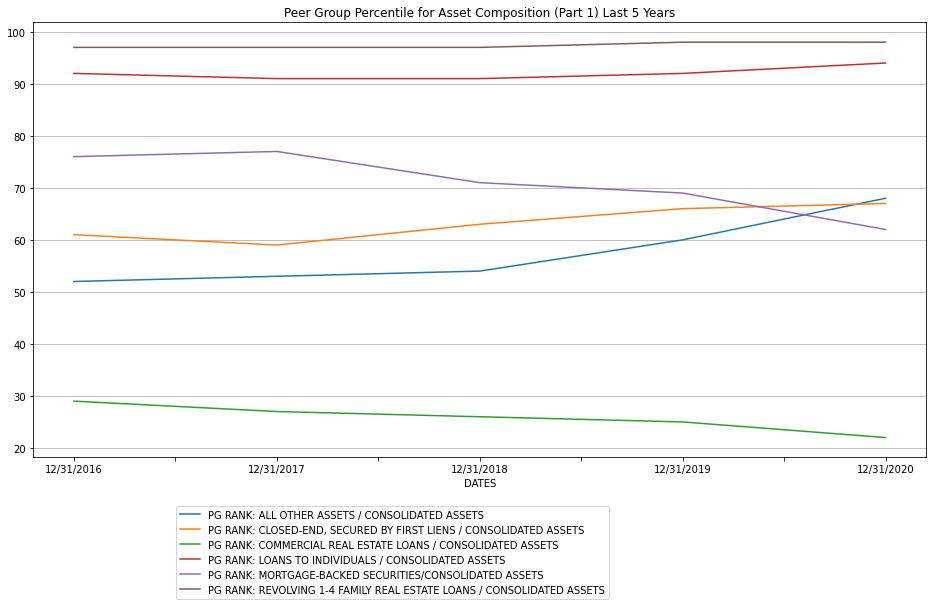

In [450]:
pgrankasscomp = peergrouplisttransform(assetcompratiolist)
df = getdata(filename, pgrankasscomp)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Asset Composition (Part 1) Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

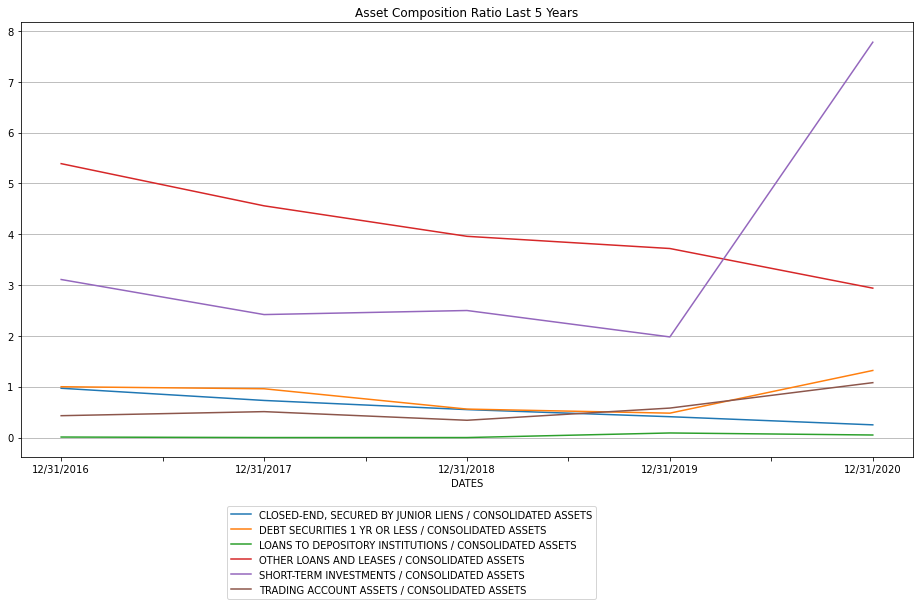

In [451]:
assetcomp2ratiolist = ['LOANS TO DEPOSITORY INSTITUTIONS / CONSOLIDATED ASSETS','TRADING ACCOUNT ASSETS / CONSOLIDATED ASSETS', 
'SHORT-TERM INVESTMENTS / CONSOLIDATED ASSETS', 'DEBT SECURITIES 1 YR OR LESS / CONSOLIDATED ASSETS', 'OTHER LOANS AND LEASES / CONSOLIDATED ASSETS',
'CLOSED-END, SECURED BY JUNIOR LIENS / CONSOLIDATED ASSETS']
df = getdata(filename, assetcomp2ratiolist)
ax = df.plot(figsize=(16,8), title='Asset Composition Ratio Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')


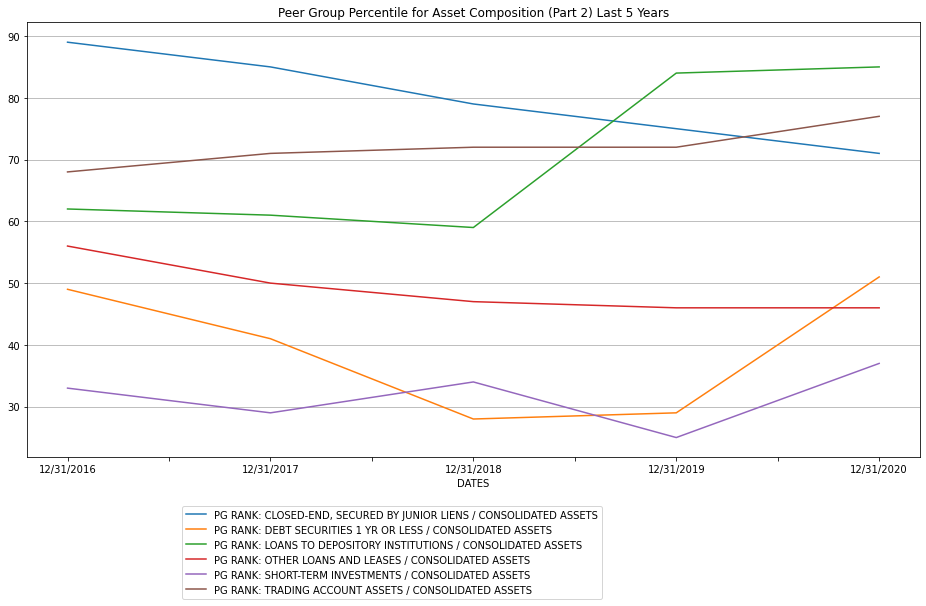

In [452]:
pgrankasscomp2 = peergrouplisttransform(assetcomp2ratiolist)
df = getdata(filename, pgrankasscomp2)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Asset Composition (Part 2) Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

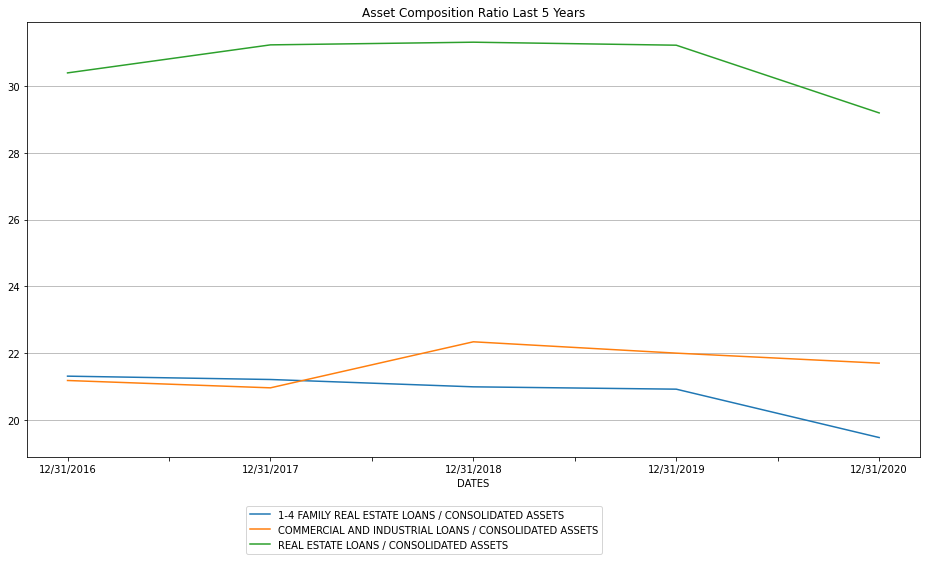

In [453]:
assetcomp3ratiolist = ['REAL ESTATE LOANS / CONSOLIDATED ASSETS',
                      'COMMERCIAL AND INDUSTRIAL LOANS / CONSOLIDATED ASSETS','1-4 FAMILY REAL ESTATE LOANS / CONSOLIDATED ASSETS']
df = getdata(filename, assetcomp3ratiolist)
ax = df.plot(figsize=(16,8), title='Asset Composition Ratio Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

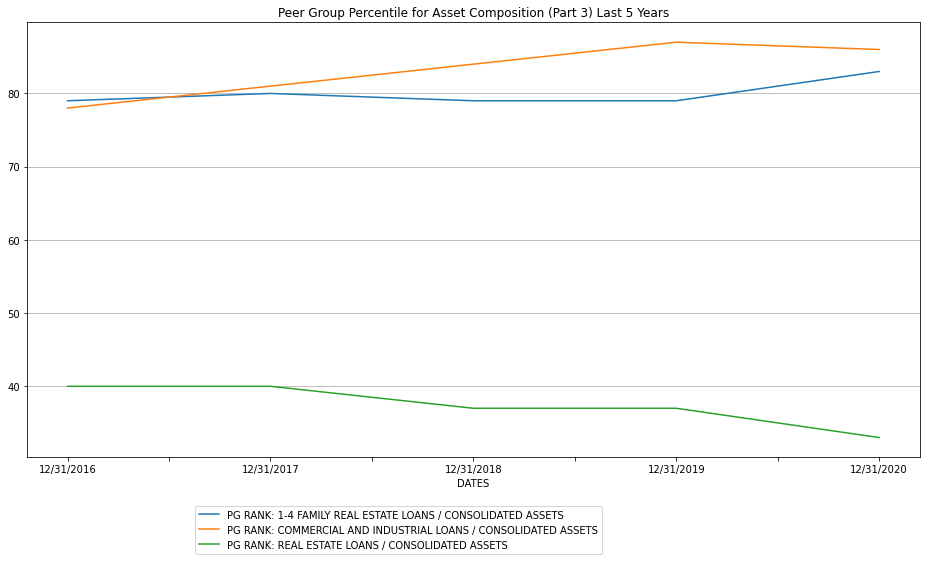

In [454]:
pgrankasscomp3 = peergrouplisttransform(assetcomp3ratiolist)
df = getdata(filename, pgrankasscomp3)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Asset Composition (Part 3) Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Liability Composition

Text(0, 0.5, 'Liabilities')

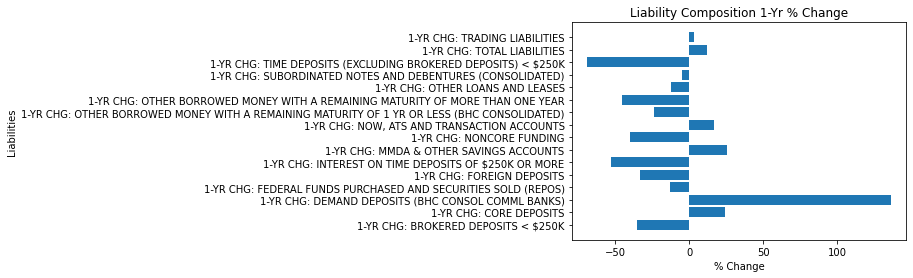

In [455]:
liabilitycompratiolist = ['1-YR CHG: DEMAND DEPOSITS (BHC CONSOL COMML BANKS)',
                      '1-YR CHG: NOW, ATS AND TRANSACTION ACCOUNTS','1-YR CHG: TIME DEPOSITS (EXCLUDING BROKERED DEPOSITS) < $250K',
                         '1-YR CHG: MMDA & OTHER SAVINGS ACCOUNTS','1-YR CHG: CORE DEPOSITS','1-YR CHG: INTEREST ON TIME DEPOSITS OF $250K OR MORE',
                         '1-YR CHG: FOREIGN DEPOSITS', '1-YR CHG: FEDERAL FUNDS PURCHASED AND SECURITIES SOLD (REPOS)','1-YR CHG: OTHER BORROWED MONEY WITH A REMAINING MATURITY OF 1 YR OR LESS (BHC CONSOLIDATED)',
                          '1-YR CHG: OTHER BORROWED MONEY WITH A REMAINING MATURITY OF MORE THAN ONE YEAR', '1-YR CHG: BROKERED DEPOSITS < $250K',
                          '1-YR CHG: NONCORE FUNDING', '1-YR CHG: TRADING LIABILITIES', '1-YR CHG: SUBORDINATED NOTES AND DEBENTURES (CONSOLIDATED)',
                          '1-YR CHG: OTHER LOANS AND LEASES','1-YR CHG: TOTAL LIABILITIES']
testcase = dt + 'downloaded.csv'
df = pd.read_csv(testcase, header =None, skiprows=15)
df.rename(columns={0: 'ID', 1:'Ratio Type', 2: 'Value'}, inplace=True)
df['Value'] = pd.to_numeric(df['Value'], errors = 'coerce')
df['COUNT'] = df.groupby(['Ratio Type']).cumcount()+1
df = df.set_index(['Ratio Type', 'COUNT'])['Value'].unstack().add_prefix('col').reset_index()
df.rename(columns={'COUNT': 'Index', 'col1': daterange2[0], 'col2':daterange2[1], 'col3': daterange2[2], 
                   'col4':daterange2[3], 'col5': daterange2[4]}, inplace=True)
df = df[df['Ratio Type'].isin(liabilitycompratiolist)]
df = df[['Ratio Type','12/31/2020']]
df.head()
plt.barh(y = df['Ratio Type'], width = df['12/31/2020'])
plt.title('Liability Composition 1-Yr % Change')
plt.xlabel('% Change')
plt.ylabel('Liabilities')

Text(0, 0.5, 'Liabilities')

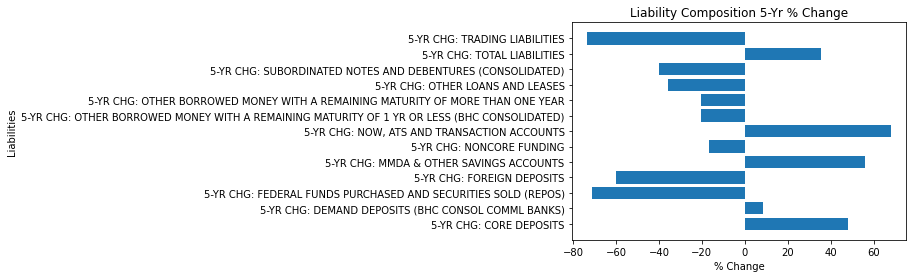

In [456]:
liabilitycompratiolist = ['5-YR CHG: DEMAND DEPOSITS (BHC CONSOL COMML BANKS)',
                      '5-YR CHG: NOW, ATS AND TRANSACTION ACCOUNTS','5-YR CHG: TIME DEPOSITS (EXCLUDING BROKERED DEPOSITS) < $250K',
                         '5-YR CHG: MMDA & OTHER SAVINGS ACCOUNTS','5-YR CHG: CORE DEPOSITS','5-YR CHG: INTEREST ON TIME DEPOSITS OF $250K OR MORE',
                         '5-YR CHG: FOREIGN DEPOSITS', '5-YR CHG: FEDERAL FUNDS PURCHASED AND SECURITIES SOLD (REPOS)','5-YR CHG: OTHER BORROWED MONEY WITH A REMAINING MATURITY OF 1 YR OR LESS (BHC CONSOLIDATED)',
                          '5-YR CHG: OTHER BORROWED MONEY WITH A REMAINING MATURITY OF MORE THAN ONE YEAR', '5-YR CHG: BROKERED DEPOSITS < $250K',
                          '5-YR CHG: NONCORE FUNDING', '5-YR CHG: TRADING LIABILITIES', '5-YR CHG: SUBORDINATED NOTES AND DEBENTURES (CONSOLIDATED)',
                          '5-YR CHG: OTHER LOANS AND LEASES','5-YR CHG: TOTAL LIABILITIES']
testcase = dt + 'downloaded.csv'
df = pd.read_csv(testcase, header =None, skiprows=15)
df.rename(columns={0: 'ID', 1:'Ratio Type', 2: 'Value'}, inplace=True)
df['Value'] = pd.to_numeric(df['Value'], errors = 'coerce')
df['COUNT'] = df.groupby(['Ratio Type']).cumcount()+1
df = df.set_index(['Ratio Type', 'COUNT'])['Value'].unstack().add_prefix('col').reset_index()
df.rename(columns={'COUNT': 'Index', 'col1': daterange2[0], 'col2':daterange2[1], 'col3': daterange2[2], 
                   'col4':daterange2[3], 'col5': daterange2[4]}, inplace=True)
df = df[df['Ratio Type'].isin(liabilitycompratiolist)]
df = df[['Ratio Type','12/31/2020']]
df.head()
plt.barh(y = df['Ratio Type'], width = df['12/31/2020'])
plt.title('Liability Composition 5-Yr % Change')
plt.xlabel('% Change')
plt.ylabel('Liabilities')

## Maturity Gap

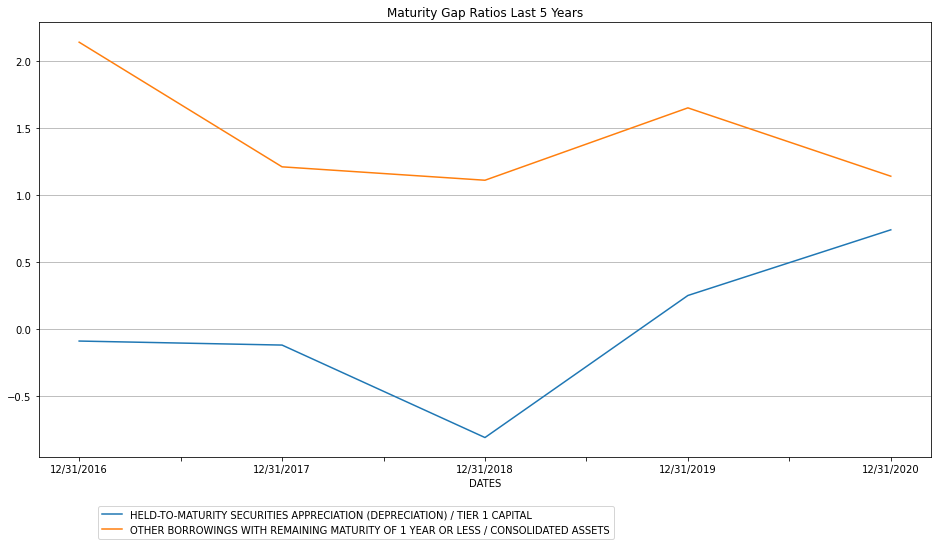

In [457]:
maturityratiolist = ['OTHER BORROWINGS WITH REMAINING MATURITY OF 1 YEAR OR LESS / CONSOLIDATED ASSETS',
                      'HELD-TO-MATURITY SECURITIES APPRECIATION (DEPRECIATION) / TIER 1 CAPITAL']
df = getdata(filename, maturityratiolist)
ax = df.plot(figsize=(16,8), title='Maturity Gap Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

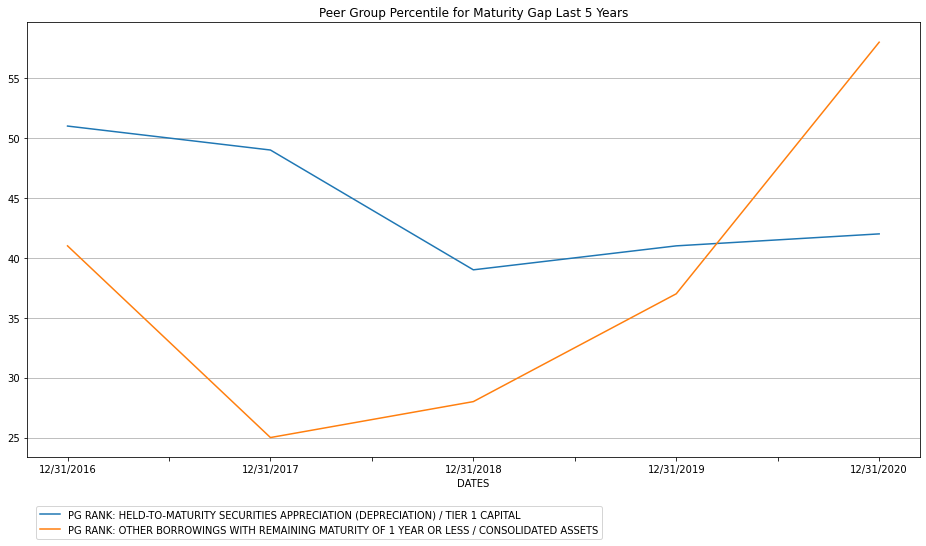

In [458]:
pgratiomaturityratiolist = peergrouplisttransform(maturityratiolist)
df = getdata(filename, pgratiomaturityratiolist)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Maturity Gap Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Interest Rate Sensitivity

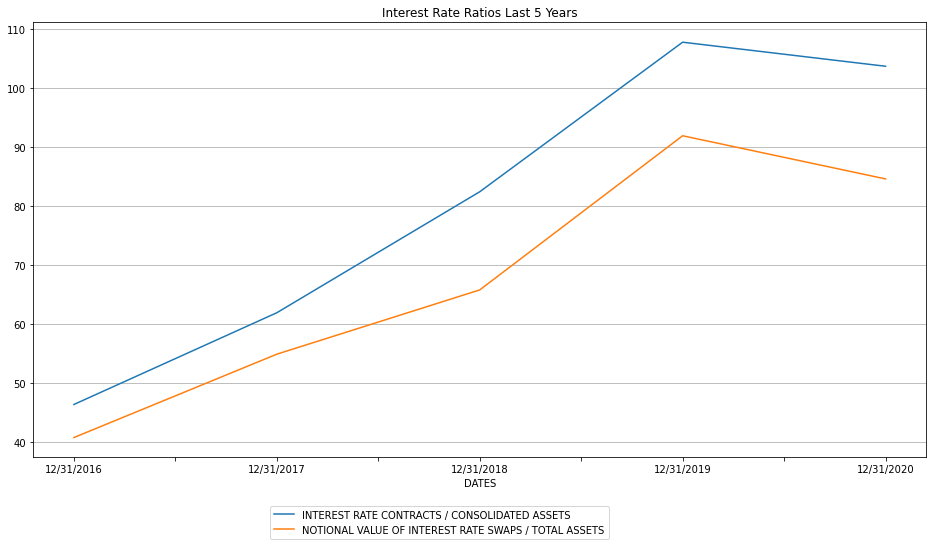

In [459]:
irratiolist = ['INTEREST RATE CONTRACTS / CONSOLIDATED ASSETS',
                'NOTIONAL VALUE OF INTEREST RATE SWAPS / TOTAL ASSETS']
df = getdata(filename, irratiolist)
ax = df.plot(figsize=(16,8), title='Interest Rate Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

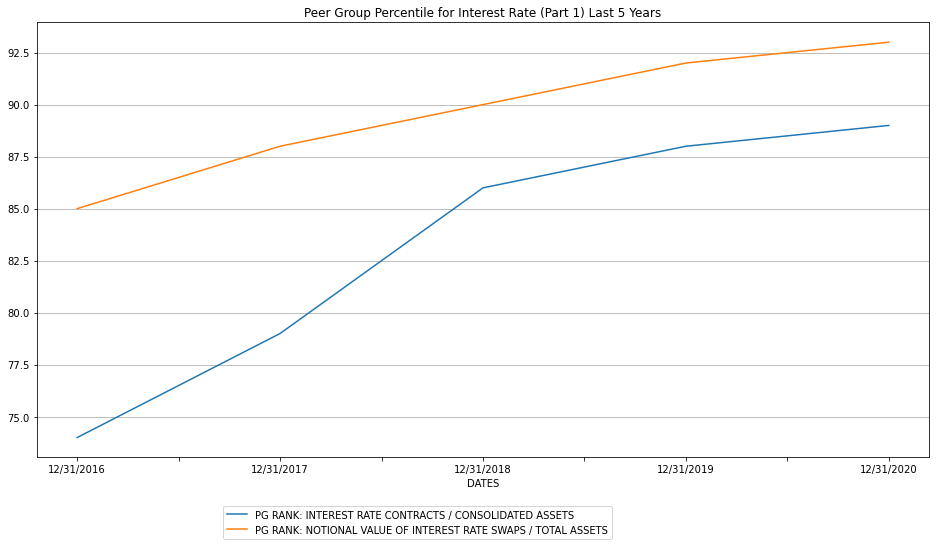

In [460]:
pgratioirratiolist = peergrouplisttransform(irratiolist)
df = getdata(filename, pgratioirratiolist)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Interest Rate (Part 1) Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

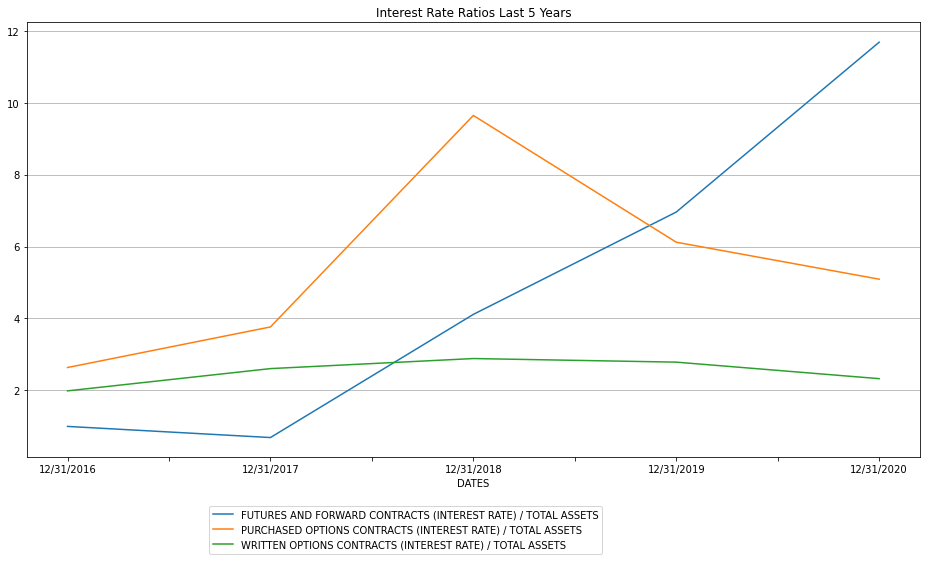

In [461]:
ir2ratiolist = ['FUTURES AND FORWARD CONTRACTS (INTEREST RATE) / TOTAL ASSETS', 'PURCHASED OPTIONS CONTRACTS (INTEREST RATE) / TOTAL ASSETS',
                      'WRITTEN OPTIONS CONTRACTS (INTEREST RATE) / TOTAL ASSETS']
df = getdata(filename, ir2ratiolist)
ax = df.plot(figsize=(16,8), title='Interest Rate Ratios Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

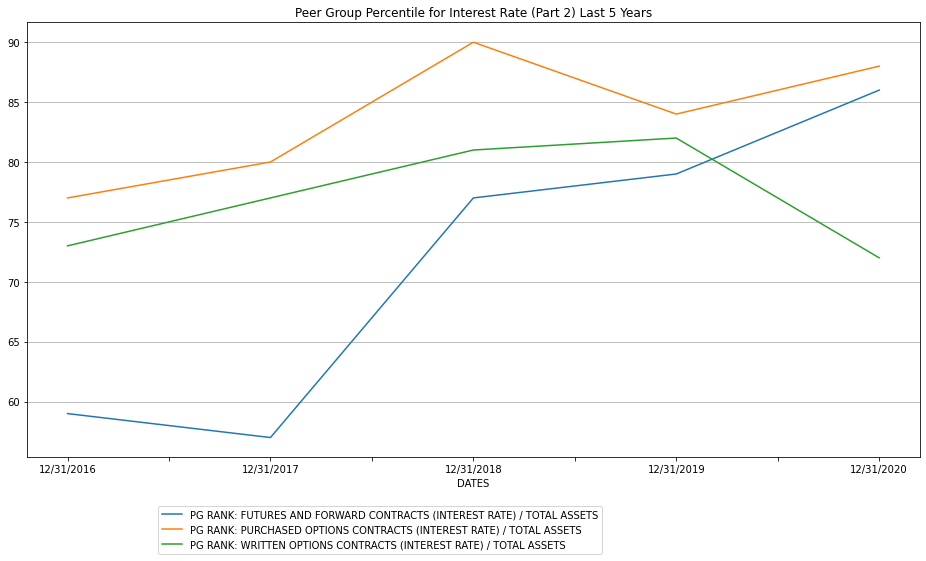

In [462]:
pgratiolistir = peergrouplisttransform(ir2ratiolist)
df = getdata(filename, pgratiolistir)
ax = df.plot(figsize=(16,8), title='Peer Group Percentile for Interest Rate (Part 2) Last 5 Years')
ax.legend(bbox_to_anchor=(0.65,-0.1))
ax.set_xlabel('DATES')
ax.grid(axis='y', linestyle='-')

## Analysis
### PG Rank Interest Rate Sensitivity
When examining the banks' PG Rank with regards to interest rate derivatives as a percentage of total assets we can see that Citizens Financial has been drastically increasing in the number of Forward, Futures and Options Contracts on Interest Rates. For these types of derivatives they have a larger portion of their total asset structure committed to them versus other banks of its size. This makes them very sensitive to interest rate changes over the next few years.

### PG Rank Asset Composition Part 1 & Past Due Ratios
When examining the asset compostition rank of Citizens Financial we can see that their two biggest asset ratios are loans to individuals and Revolving I-4 Family loans. While we can see that they have decreased their overall number of Revolving I-4 loans they still remain above the 90th percentile in both of these areas. Also when you examine the Past Due data for the 30-89 and 90+ Days time frame the largest set of past due payments on loans is in their loans to individuals. While their peer group ranking for past due loans of this type is about average, an increase in this ranking over the next few years could be problematic for them since it is a big portion of their asset composition.

### PG Rank Dividends/NI
In the past 4 years Citizens has increased from the 25th percentile for this ratio to the 90th percentile by YE 2020. This is likely due to the fact that their dividend has increased 2x what it was at the end of 2017.

### Revenues and Expenses
The banks primary revenue sources are: 

1. INTEREST AND FEES ON LOANS 
2. FULLY TAXABLE INTEREST INCOME ON LOANS AND LEASES 
3. TE INCOME ON LOANS AND LEASES 

These have been increasing linearly since 2016 with the exception of 2020 where there was significant revenue drop off.

# Section 5
## Risk Profile of Citizens Financial Group, Inc

### Operational Risks:

Operational risk and losses can result from internal and external fraud; improper conduct or errors by employees or third parties; failure to document transactions properly or to obtain proper authorization; failure to comply with applicable regulatory requirements and conduct of business rules; equipment failures, including those caused by natural disasters or by electrical, telecommunications or other essential utility outages; business continuity and data security system failures, including those caused by computer viruses, cyber-attacks against the bank or its vendors, or unforeseen problems encountered while implementing major new computer systems or upgrades to existing systems; or the inadequacy or failure of systems and controls, including those of the bank’s suppliers or counterparties. Any weakness in these systems or controls, or any breaches or alleged breaches of such laws or regulations, could result in increased regulatory supervision, enforcement actions and other disciplinary action, and have an adverse impact on the business, applicable authorizations and licenses, reputation, and results of operations. Bank’s reliance on work-from-home capabilities and the potential inability to maintain critical staff in our operational facilities present risks associated with the local infrastructure, restrictive stay-at-home orders across jurisdictions, illness, quarantines, and the sustainability of a work-from-home environment, as well as heightened cybersecurity, information security and operational risks. Any disruption to the bank’s ability to deliver financial products or services to, or interact with, their clients and customers could result in losses or increased operational costs, regulatory fines, penalties or other sanctions, or harm to the bank’s reputation.

### Changes in interest rates may have an adverse effect on the bank’s profitability:

Net interest income historically has been a significant component of the bank’s total revenue. This is because a high percentage of bank’s assets and liabilities have been and will likely continue to be in the form of interest-bearing or interest-related instruments. Changes in interest rates can have a material effect on many areas of the bank’s business, including net interest income, deposit costs, loan volume and delinquency, and the value of their mortgage servicing rights.

### The bank is subject to a variety of cybersecurity risks that, if realized, could adversely affect how their business:

Two of the most significant cyber-attack risks faced by the bank are e-fraud and loss of sensitive customer data. Loss from e-fraud occurs when cybercriminals extract funds directly from customers’ or bank’s accounts using fraudulent schemes that may include Internet-based funds transfers. The bank has been subject to several e-fraud incidents historically. It has also been subject to attempts to steal sensitive customer data, such as account numbers and social security numbers, through unauthorized access to their computer systems including computer hacking. Such attacks are less frequent but could present significant reputational, legal, and regulatory costs to the bank if successful.

### Off-Balance Sheet Risks:

Liquidity risk can be heightened by several factors, including an over-reliance on a particular source of funding (including, for example, secured FHLB advances), changes in credit ratings or market-wide phenomena such as market dislocation and major disasters. The bank’s reliance on customer deposits to meet a considerable portion of their funding has grown over recent years, and we continue to seek to increase the proportion of our funding represented by customer deposits. However, these deposits are subject to fluctuation due to certain factors, such as increasing competitive pressures for retail or corporate customer deposits, changes in interest rates and returns on other investment classes, or a loss of confidence by customers in the bank or in the banking sector generally which could result in a significant outflow of deposits within a short period of time. To the extent there is heightened competition among U.S. banks for retail customer deposits, this competition may increase the cost of procuring new deposits and/or retaining existing deposits, and otherwise negatively affect the bank’s ability to grow their deposit base. An inability to grow, or any material decrease in, the bank’s deposits could have a material adverse effect on their ability to satisfy their liquidity needs.

There is a risk that corporate and financial institution counterparties may seek to reduce their credit exposures to banks and other financial institutions (for example, reductions in unsecured deposits supplied by these counterparties), which may cause funding from these sources to no longer be available. Under these circumstances, the bank may need to seek funds from alternative sources, potentially at higher costs than has previously been the case or may be required to consider disposals of other assets not previously identified for disposal, to reduce the bank’s funding commitments.

### Liability side risks:

Credit ratings affect the cost and other terms upon which the bank can obtain funding. Rating agencies regularly evaluate the bank, and their ratings are based on several factors, including bank’s financial strength. Other factors considered by rating agencies include conditions affecting the financial services industry generally. Any downgrade in the bank’s ratings would likely increase their borrowing costs, could limit their access to capital markets, and otherwise adversely affect their business. For example, a ratings downgrade could adversely affect our ability to sell or market certain of the bank’s securities, including long-term debt, engage in certain longer-term derivatives transactions and retain the bank’s customers, particularly corporate customers who may require a minimum rating threshold to place funds with the bank. In addition, under the terms of certain of our derivatives contracts, the bank may be required to maintain a minimum credit rating or have to post additional collateral or terminate such contracts. Any of these results of a rating downgrade could increase the bank’s cost of funding, reduce their liquidity, and have adverse effects on the bank’s business, financial condition, and results of operations.

### Asset side risks:

The bank has exposure to many different industries and risks arising from actual or perceived changes in credit quality and uncertainty over the recoverability of amounts due from borrowers is inherent in our businesses. Our exposure may be exacerbated by the geographic concentration of our operations, which are predominately located in the New England, Mid-Atlantic and Midwest regions. The credit quality of our borrowers may deteriorate for a number of reasons that are outside our control, including as a result of prevailing economic and market conditions and asset valuation. The trends and risks affecting borrower credit quality, particularly in the New England, Mid-Atlantic and Midwest regions, have caused, and in the future may cause, us to experience impairment charges, increased repurchase demands, higher costs, additional write-downs and losses and an inability to engage in routine funding transactions, which could have a material adverse effect on our business, financial condition, and results of operations.

### Regulatory Risks:

As a financial holding company and a bank holding company, the bank is subject to comprehensive regulation, supervision, and examination by the FRB. Such forms of supervisory action could include, without limitation, written agreements, cease and desist orders, and consent orders and may, among other things, result in restrictions on our ability to pay dividends, requirements to increase capital, restrictions on our activities, the imposition of civil monetary penalties, and enforcement of such actions through injunctions or restraining orders. The bank could also be required to dispose of certain assets and liabilities within a prescribed period. The terms of any such supervisory or enforcement action could have a material adverse effect on their business, financial condition, and results of operations. In recent years, the bank has faced particularly intense scrutiny, with many new regulatory initiatives and vigorous oversight and enforcement on the part of numerous regulatory and governmental authorities. Legislatures and regulators have pursued a broad array of initiatives intended to promote the safety and soundness of financial institutions, financial market stability, the transparency and liquidity of financial markets, and consumer and investor protection.

The bank is subject to capital adequacy and liquidity standards, and if it fails to meet these standards the bank’s financial condition and operations would be adversely affected.

The bank is subject to rules and regulations regarding money laundering and the financing of terrorism. Monitoring compliance with anti-money laundering and anti-terrorism financing rules can put a significant financial burden on the bank and poses significant technical challenges.

# Section 6
## Off-Balance Sheet 

### 1. Off Balance Sheet Growth Over Years
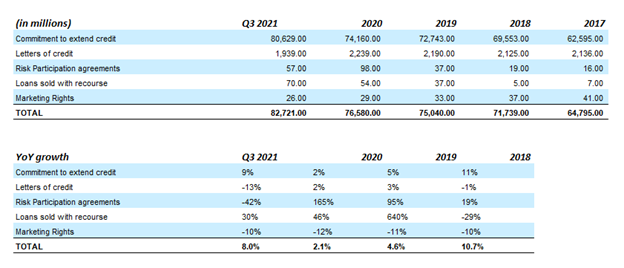

Observing the off-balance sheet growth from 2017, we note that it grows noticeably between 2017-2018 while the growth slows during the period from 2018-2020. However, between YE 2020 and Q3 2021 its has grown at 8.0%. Over the years the securitization activities of the bank have increased significantly as has its risk participation activities. The largest contributions to the off-balance sheet items are ‘Commitment to extend credit’ and ‘Letters of Credit’.

As of YE 2020, the Off-balance sheet stands at 76.6 billion which increased to 82.7 billion by Q3 2021.

### 2.	Components of the off-balance sheet

The off-balance sheet components of the bank’s balance sheet include the following: 

#### a.	Commitment to extend credit:
These are agreements the bank has in place with its customers where they agree to lend to customers in accordance with conditions contractually agreed upon in advance. These commitments have fixed expiration dates or termination clauses and may require payment of a fee. Usually, these commitments are expected to expire without being drawn upon. Hence the contract amounts are not necessarily indicative of future cash requirements.
As of YE 2020, the commitment to extend credit for the bank stood at 74.2 billion which has increased to 80.6 million in Q3 2021. 

#### b.	Letters of credit (LoC)
An LoC is a document issued by a bank on behalf of its customer authorizing a 3rd party to draw drafts on the bank up to a stipulated amount under specific terms and conditions. It is conditional commitment (except when prepaid by the account party) on the bank’s part to pay drafts drawn in accordance with the document’s terms. 
For Citizens Financial Group (CFG) the LoC’s reflect commercial, standby financial and standby performance letters of credit. Commercial Letter of Credit are issued to facilitate trade of commerce. A Standby Letter of Credit (SBLC) are conditional guarantees of payment to a third party – either financial-oriented (the customer either fails to make specific payments) or performance-oriented (the customer fails to complete a specific project).
As of YE 2020, the commitment towards letters of credit for the bank stood at 2.24 billion which has reduced to 1.9 billion in Q3 2021. 

#### c.	Risk participation agreements
Risk Participation Agreements (RPAs) are guarantees issued by the bank to other parties for a fee, whereby the bank agrees to participate in the credit risk of a derivative customer of the other party. The current credit exposure is spread over 77 counterparties. At September 30, 2021, the remaining terms on these RPAs ranged from less than one year to eight years.
As of YE 2020, the RPA commitment of the bank stands at 98 million which has reduced to 57 million in Q3 2021. 

#### d.	Loans sold with recourse
A recourse obligation arises when a bank transfers assets in a sale and retains an obligation to repurchase the assets/absorb losses. Recourse also exists implicitly where the bank provides credit enhancements beyond any contractual obligation to support assets it sold.
As of YE 2020, the commitment towards loans sold with recourse for the bank stood at 54 million, increased to 70 million in Q3 2021. 

#### e.	Marketing rights
During 2003, the bank entered into a 25-year agreement to acquire the naming and marketing rights of a baseball stadium in Pennsylvania.
As of YE 2020, the commitment towards these marketing rights stood at 29 million, reduced to 26 million in Q3 2021. 

### 3.	Bank’s derivative usage
As part of its operations the bank enters into a variety of derivative transactions to meet the financing needs of its customers and to reduce its own exposure interest and currency rate fluctuations. It does not use derivatives for speculation. Derivative assets and liabilities are netted by counterparty and netted against collateral according to the master netting agreement. 

As of YE 2020, the total derivative assets and derivative liabilities stood at 1.92 billion and 128 million respectively. As of Q3 2021, these values have changed to 1.77 billion and 187 million respectively.
The derivative transactions are internally divided into three sub-groups: institutional, customer and residential loan. Certain derivative transactions within these sub-groups are designated as fair value or cash flow hedges which impacts its accounting treatment.

### Derivatives Designated as Hedging Instruments
Institutional derivatives qualify for hedge accounting treatment. All hedging relationships, risk management objectives and strategies and effectiveness of the hedges are monitored during the hedging period.  Hedge accounting treatment is discontinued when it is determined that a derivative is ceases to be effective as a hedge.

### Derivatives Not Designated As Hedging Instruments
Economic hedges include those related to offsetting customer derivatives, residential mortgage loan derivatives and derivatives to hedge its residential MSR (Mortgage Servicing Rights) portfolio. Customer derivatives include interest rate, foreign exchange and commodity derivative contracts to needs of the bank’s customers and are economically hedged by the bank to offset its market exposure. As of YE 2020, the total economic hedge contribution to non-interest income stood at 443 million.


### 4.	Securitization activities
The bank sells residential mortgages to GSEs and other parties who may issue securities backed by pools of such loans. It retains no beneficial interests in these sales but may retain the servicing rights for the loans sold. In case of a violation of representation or warranties of a loan it may exercise its option or be obligated to repurchase to repurchase such a loan. 
Mortgage loans held for sale are accounted at fair value. The unpaid principal balance of residential mortgage loans related to MSR was 87.4 billion and 81.2 billion as of Q3 2021 and YE 2020, respectively.

The bank treats its right to service residential mortgage loans for others (MSRs) as separate assets and are initially recorded at fair value. Subsequent to the initial recognition, MSRs are measured using either the fair value method or the amortization method. Effective January 1, 2020, the bank opted to account for all MSRs previously under the amortization method as under the fair value method. Post he change a cumulative effect adjustment to retained earnings of $6 million (net of taxes) was recognized. 

Occasionally the bank also engages in other servicing relationships. The unpaid principal value balance of this activity stands at 876 million and 1025 million as of Q3 2021 and YE 2020 respectively.

### 5.	Level 1, level 2 and level 3 assets of the bank
The bank measures fair value using the price that would be received to sell an asset or paid to transfer a liability between market participants at the measurement date. Fair value is based upon quoted market prices in an active market, where available. If quoted prices are not available, observable market-based inputs or independently sourced parameters are used to develop fair value, whenever possible. Such inputs may include prices of similar assets or liabilities, yield curves, interest rates, prepayment speeds, and foreign exchange rates.

Citizens classifies its assets and liabilities that are carried at fair value in accordance with the three-level valuation hierarchy, where classifications are reviewed on a quarterly basis:

#### o	Level 1. Quoted prices (unadjusted) in active markets for identical assets or liabilities.
#### o	Level 2. Observable inputs other than Level 1 prices, such as quoted prices for similar instruments, quoted prices in markets that are not active, or other inputs that are observable or can be corroborated by market data for substantially the full term of the asset or liability.
#### o	Level 3. Unobservable inputs that are supported by little or no market information and that are significant to the fair value measurement.

Broadly the following assets types are classified under each of the levels:

#### -	Level 1: Equity Securities and US Treasury debt
#### -	Level 2: residential mortgage LHFS (loans held for sale), commercial & industrial real estate loans, commercial real estate loans, specified pool mortgage “pass-through” securities, debt issued by U.S. GSEs and state/political subdivisions, interest rate swaps, foreign exchange derivatives, TBA (to be announced mortgage securities) contracts, forward sales commitments of residential MBS and collateral dependent impaired loans
#### -	Level 3: securities backed by education loan, MSRs and interest rate lock commitments

As of YE 2020 total assets classified as Level 1, Level 2 and level 3 were 77mln, 28.45bn and 855mln respectively. The total liabilities classified as Level 1, Level 2 and level 3 were 0, 634mln and 0 respectively.
As of Q3 2021 total assets classified as Level 1, Level 2 and level 3 were 99mln, 30.12bn and 1.03bn respectively. The total liabilities classified as Level 1, Level 2 and level 3 were 0, 1.21bn and 0 respectively.